In [1]:
# logistic regression classification modeling

In [2]:
## ** INPUT REQUIRED **
# add filtering option for backtest or live predictions

In [3]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from fpdf import FPDF
from datetime import datetime


In [4]:
# --- Load dataset ---
df = pd.read_csv("wr_nfl_df_sorted_new_features_final.csv")

# --- Inspect the hit_value_dk target column ---
print("🔍 Value Counts:")
print(df["hit_value_dk"].value_counts(dropna=False))

print("\n🔍 Data Type:", df["hit_value_dk"].dtype)
print("❓ Missing Values:", df["hit_value_dk"].isnull().sum())

proportion = df["hit_value_dk"].mean()
print(f"\n✅ Proportion of hits (1's): {proportion:.2%}")


🔍 Value Counts:
hit_value_dk
False    11026
True      6423
Name: count, dtype: int64

🔍 Data Type: bool
❓ Missing Values: 0

✅ Proportion of hits (1's): 36.81%


In [5]:
### Begin: Determine Targets ###

In [6]:
# check potential targets
targets_to_check = [
    "hit_value_dk",
    "hit_value_fd",
    "rec_ge_7",
    "fpts_performance_bin",
    "value_ratio_dk_log_performance_bin"
]

for col in targets_to_check:
    print(f"\n📊 {col}")
    print("Value Counts:\n", df[col].value_counts(dropna=False))
    print("Data Type:", df[col].dtype)
    print("Missing Values:", df[col].isnull().sum())

    if df[col].dropna().nunique() == 2 and df[col].dtype != 'object':
        prop = df[col].mean()
        print(f"Proportion of 1's: {prop:.2%}")



📊 hit_value_dk
Value Counts:
 hit_value_dk
False    11026
True      6423
Name: count, dtype: int64
Data Type: bool
Missing Values: 0
Proportion of 1's: 36.81%

📊 hit_value_fd
Value Counts:
 hit_value_fd
False    12142
True      5307
Name: count, dtype: int64
Data Type: bool
Missing Values: 0
Proportion of 1's: 30.41%

📊 rec_ge_7
Value Counts:
 rec_ge_7
0    15642
1     1807
Name: count, dtype: int64
Data Type: int64
Missing Values: 0
Proportion of 1's: 10.36%

📊 fpts_performance_bin
Value Counts:
 fpts_performance_bin
below_avg        4211
top_performer    4186
average          4154
above_avg        4118
NaN               780
Name: count, dtype: int64
Data Type: object
Missing Values: 780

📊 value_ratio_dk_log_performance_bin
Value Counts:
 value_ratio_dk_log_performance_bin
below_avg        3710
top_performer    3667
average          3636
above_avg        3603
NaN              2833
Name: count, dtype: int64
Data Type: object
Missing Values: 2833


In [7]:
# Simulates value return tiers using a 3-tier system based on scaled value ratios.

# Parameters:
# - df: DataFrame containing 'fpts' and salary columns
# - lower: Lower threshold (float), e.g., 0.5
# - upper: Upper threshold (float), e.g., 2.0
# - platform: 'dk' or 'fd' to determine salary column

# Returns:
# - Simulated tier Series with labels: underperformed, good_return, elite_return

def simulate_value_tiers(df, lower, upper, platform="dk"):
  
    if platform not in ["dk", "fd"]:
        raise ValueError("Platform must be 'dk' or 'fd'")

    salary_col = "dk_salary" if platform == "dk" else "fd_salary"
    value_ratio_scaled = df["fpts"] / (df[salary_col] / 1000)

    # Apply 3-tier binning
    bins = [-np.inf, lower, upper, np.inf]
    labels = ["underperformed", "good_return", "elite_return"]

    simulated_tiers = pd.cut(
        value_ratio_scaled,
        bins=bins,
        labels=labels,
        include_lowest=True
    )

    # Print output
    print(f"\n📊 Tier Distribution ({platform.upper()}):")
    print(simulated_tiers.value_counts(dropna=False))

    print(f"\n📈 Tier Proportions ({platform.upper()}):")
    print(simulated_tiers.value_counts(normalize=True, dropna=False).apply(lambda x: f"{x:.2%}"))

    return simulated_tiers


In [8]:
# Define threshold boundaries
lower = 0.5
upper = 2.0

# Run DK and FD simulations using shared thresholds
simulate_value_tiers(df, lower=lower, upper=upper, platform="dk")
simulate_value_tiers(df, lower=lower, upper=upper, platform="fd")



📊 Tier Distribution (DK):
good_return       6453
underperformed    5195
elite_return      2968
NaN               2833
Name: count, dtype: int64

📈 Tier Proportions (DK):
good_return       36.98%
underperformed    29.77%
elite_return      17.01%
NaN               16.24%
Name: proportion, dtype: object

📊 Tier Distribution (FD):
good_return       6453
underperformed    6195
NaN               2833
elite_return      1968
Name: count, dtype: int64

📈 Tier Proportions (FD):
good_return       36.98%
underperformed    35.50%
NaN               16.24%
elite_return      11.28%
Name: proportion, dtype: object


0           good_return
1           good_return
2          elite_return
3           good_return
4          elite_return
              ...      
17444    underperformed
17445    underperformed
17446    underperformed
17447    underperformed
17448       good_return
Length: 17449, dtype: category
Categories (3, object): ['underperformed' < 'good_return' < 'elite_return']

In [9]:
# Define threshold boundaries
lower = 1.0
upper = 2.0

# Run DK and FD simulations using shared thresholds
simulate_value_tiers(df, lower=lower, upper=upper, platform="dk")
simulate_value_tiers(df, lower=lower, upper=upper, platform="fd")



📊 Tier Distribution (DK):
underperformed    8304
good_return       3344
elite_return      2968
NaN               2833
Name: count, dtype: int64

📈 Tier Proportions (DK):
underperformed    47.59%
good_return       19.16%
elite_return      17.01%
NaN               16.24%
Name: proportion, dtype: object

📊 Tier Distribution (FD):
underperformed    9382
good_return       3266
NaN               2833
elite_return      1968
Name: count, dtype: int64

📈 Tier Proportions (FD):
underperformed    53.77%
good_return       18.72%
NaN               16.24%
elite_return      11.28%
Name: proportion, dtype: object


0        underperformed
1        underperformed
2          elite_return
3           good_return
4          elite_return
              ...      
17444    underperformed
17445    underperformed
17446    underperformed
17447    underperformed
17448       good_return
Length: 17449, dtype: category
Categories (3, object): ['underperformed' < 'good_return' < 'elite_return']

In [10]:
### End: Determine Targets ###

In [11]:
### Begin: experimental logistic regression modeling  ###

In [12]:
# Create  Binary Target
dk_tiers = simulate_value_tiers(df, lower=1.0, upper=2.0, platform="dk")
is_elite_return_dk = dk_tiers == "elite_return"


# Select Feature Columns
features = [
    "targets",
    "receptions",
    "rolling_fpts_diff_dk",
    "value_ratio_dk_log",
    "z_fpts_diff_dk",
    "tgt_ge_7"
]



📊 Tier Distribution (DK):
underperformed    8304
good_return       3344
elite_return      2968
NaN               2833
Name: count, dtype: int64

📈 Tier Proportions (DK):
underperformed    47.59%
good_return       19.16%
elite_return      17.01%
NaN               16.24%
Name: proportion, dtype: object


In [13]:
# subset features from df into a temporary X variable
X = df[features].copy()
y = is_elite_return_dk.copy()

In [14]:
# setup the train-test split
# train on seasons < 2023
# validation on season 2023
# final test on 2024


# Mask for seasons
mask_2024 = df["season"] == 2024
mask_2023 = df["season"] == 2023
mask_pre_2023 = df["season"] < 2023

# Full null check mask
mask_all_valid = X.notnull().all(axis=1) & y.notnull()

# Training set: Pre-2023
mask_train = mask_all_valid & mask_pre_2023
X_train = X[mask_train]
y_train = y[mask_train]

# Validation set: 2023
mask_val = mask_all_valid & mask_2023
X_val = X[mask_val]
y_val = y[mask_val]

# Final test set: 2024
mask_test = mask_all_valid & mask_2024
X_test_final = X[mask_test]
y_test_final = y[mask_test]

# Summary
print(f"Training samples:         {len(X_train)}")
print(f"Validation (2023):        {len(X_val)}")
print(f"Final Test (2024):        {len(X_test_final)}")

print("\nClass Distribution:")
print("Train:\n", y_train.value_counts(normalize=True).apply(lambda x: f"{x:.2%}"))
print("Val:\n", y_val.value_counts(normalize=True).apply(lambda x: f"{x:.2%}"))
print("Test:\n", y_test_final.value_counts(normalize=True).apply(lambda x: f"{x:.2%}"))


Training samples:         10699
Validation (2023):        2059
Final Test (2024):        1858

Class Distribution:
Train:
 False    79.00%
True     21.00%
Name: proportion, dtype: object
Val:
 False    80.96%
True     19.04%
Name: proportion, dtype: object
Test:
 False    82.29%
True     17.71%
Name: proportion, dtype: object


In [15]:
# Import and Initialize the Model

# Create a logistic regression model object
# Use balanced class weights to account for slight imbalance
logreg_model = LogisticRegression(
    penalty=None,               # No regularization for now (keep math pure)
    solver='lbfgs',             # Robust optimizer
    class_weight='balanced',    # Compensate for 21/79 class ratio
    max_iter=1000,              # Extra room for convergence
    random_state=42
)


In [16]:
# Fit the model on training data
logreg_model.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, penalty=None,
                   random_state=42)

In [17]:
# View and Interpret the Model Coefficients
# View learned coefficients with their corresponding feature names
coefficients = pd.Series(
    logreg_model.coef_[0],
    index=X_train.columns
).sort_values(ascending=False)

print("🔎 Logistic Regression Coefficients:")
print(coefficients)


🔎 Logistic Regression Coefficients:
value_ratio_dk_log      112.815383
z_fpts_diff_dk            1.651549
receptions                0.033509
targets                  -0.019074
rolling_fpts_diff_dk     -0.099089
tgt_ge_7                 -0.346638
dtype: float64


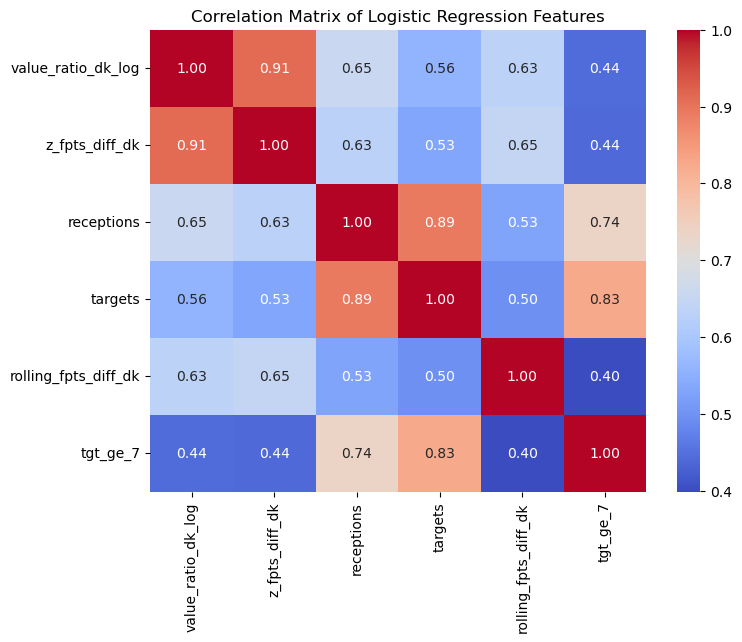

In [18]:
# Correlation Matrix Among Features
# Spot collinearity and detect proxy behavior

# Only use the features from the model
feature_cols = [
    "value_ratio_dk_log",
    "z_fpts_diff_dk",
    "receptions",
    "targets",
    "rolling_fpts_diff_dk",
    "tgt_ge_7"
]

# Compute correlation matrix (drop NaNs just in case)
corr_matrix = df[feature_cols].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Logistic Regression Features")
plt.show()


In [19]:
# Apply regression to determine the following:
# How much z_fpts_diff_dk explains the variation in value_ratio_dk_log

# Drop rows with missing values in either variable
mask = df["value_ratio_dk_log"].notnull() & df["z_fpts_diff_dk"].notnull()
x = df.loc[mask, "z_fpts_diff_dk"]
y = df.loc[mask, "value_ratio_dk_log"]

# Add constant for intercept
x_with_const = sm.add_constant(x)

# Fit linear regression
model = sm.OLS(y, x_with_const).fit()

# View results
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:     value_ratio_dk_log   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                 7.184e+04
Date:                Sat, 21 Jun 2025   Prob (F-statistic):               0.00
Time:                        16:38:14   Log-Likelihood:                 3141.2
No. Observations:               14616   AIC:                            -6278.
Df Residuals:                   14614   BIC:                            -6263.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.6631      0.002    410.

In [20]:
# Drop NaNs for both features
mask = df["receptions"].notnull() & df["targets"].notnull()
x = df.loc[mask, "targets"]
y = df.loc[mask, "receptions"]

# Add constant for intercept
x_with_const = sm.add_constant(x)

# Fit linear regression model
model_targets_to_rec = sm.OLS(y, x_with_const).fit()

# Display summary
print(model_targets_to_rec.summary())


                            OLS Regression Results                            
Dep. Variable:             receptions   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                 6.834e+04
Date:                Sat, 21 Jun 2025   Prob (F-statistic):               0.00
Time:                        16:38:14   Log-Likelihood:                -26959.
No. Observations:               17449   AIC:                         5.392e+04
Df Residuals:                   17447   BIC:                         5.394e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0881      0.015     -5.928      0.0

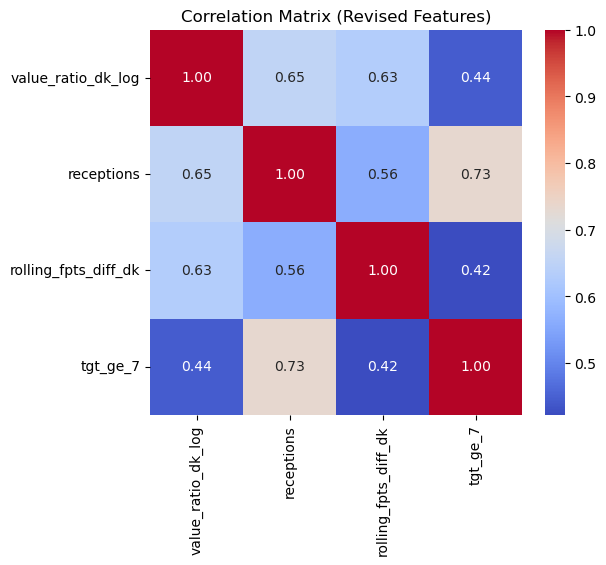

In [21]:
# Revised feature list
features_revised = [
    "value_ratio_dk_log",
    "receptions",
    "rolling_fpts_diff_dk",
    "tgt_ge_7"
]

# Compute correlation matrix (drop NaNs)
corr_matrix_revised = df[features_revised].dropna().corr()

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix_revised, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix (Revised Features)")
plt.show()


In [22]:
# explore more features
candidate_features = [
    "catch_percentage",
    "catch_percentage_scaled",
    "catch_percentage_scaled_z",
    "fpts_3wk_avg",
    "avg_cushion",
    "avg_separation",
    "avg_intended_air_yards",
    "percent_share_of_intended_air_yards"
]

# Count non-null values
df[candidate_features].notnull().sum().sort_values(ascending=False)


fpts_3wk_avg                           12308
catch_percentage                        8199
catch_percentage_scaled                 8199
catch_percentage_scaled_z               8199
avg_separation                          8199
avg_intended_air_yards                  8199
percent_share_of_intended_air_yards     8199
avg_cushion                             8197
dtype: int64

In [23]:
# Revised features list
features_final = [
    "value_ratio_dk_log",
    "receptions",
    "rolling_fpts_diff_dk",
    "tgt_ge_7",
    "fpts_3wk_avg"
]


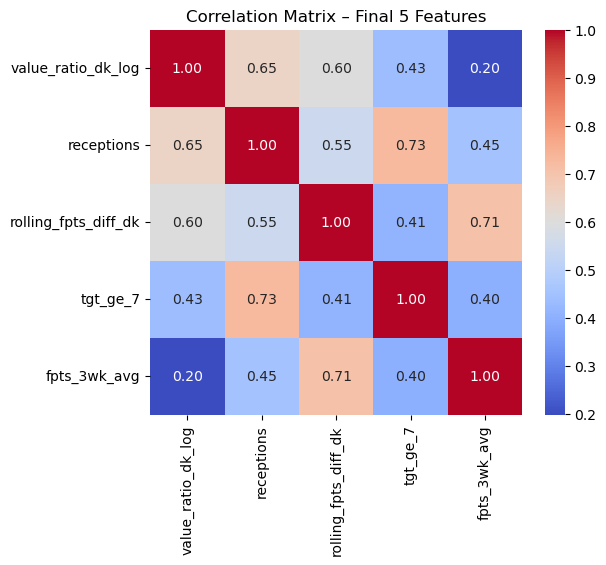

In [24]:
# Correlation check on final feature set
df[features_final].dropna().corr()

plt.figure(figsize=(6, 5))
sns.heatmap(df[features_final].dropna().corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix – Final 5 Features")
plt.show()


In [25]:
# Create Train / Validation / Test Sets
# Create season masks
mask_2024 = df["season"] == 2024
mask_2023 = df["season"] == 2023
mask_pre_2023 = df["season"] < 2023

# Create modeling mask (no missing values)
valid_mask = df[features_final].notnull().all(axis=1) & y.notnull()

# Create X and y matrices
X = df[features_final]

X_train = X[valid_mask & mask_pre_2023]
y_train = y[valid_mask & mask_pre_2023]

X_val = X[valid_mask & mask_2023]
y_val = y[valid_mask & mask_2023]

X_test = X[valid_mask & mask_2024]
y_test = y[valid_mask & mask_2024]


In [26]:
# rerun the logistic mode based on modifications to the features

# Re-initialize the logistic model (no changes needed here)
logreg_model_final = LogisticRegression(
    penalty=None,
    solver='lbfgs',
    class_weight='balanced',
    max_iter=10000,
    random_state=42
)

# Fit model on finalized training data
logreg_model_final.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=10000, penalty=None,
                   random_state=42)

In [27]:
# This pulls from the correct model object and feature set
pd.Series(
    logreg_model_final.coef_[0],
    index=features_final
).sort_values(ascending=False)


value_ratio_dk_log      108.625975
fpts_3wk_avg             10.410099
rolling_fpts_diff_dk     -9.941595
tgt_ge_7                -22.564580
receptions             -292.720402
dtype: float64

In [28]:
# Revised model and features

# # --- Define Final Feature Sets ---
features_simplified = [
    "receptions",
    "rolling_fpts_diff_dk",
    "fpts_3wk_avg"
]

# # --- Define Final Feature Sets ---
# features_simplified = [
#     "targets",
#     "rolling_fpts_diff_dk",
#     "fpts_3wk_avg"
# ]

features_with_tgt = features_simplified + ["tgt_ge_7"]

# add targets back into the training set
X_train["targets"] = df.loc[X_train.index, "targets"]

# --- Prepare Clean Subsets (Drop Rows with Missing Values) ---
X_train_simple = X_train[features_simplified].dropna()
y_train_simple = y_train.loc[X_train_simple.index]

X_train_with_tgt = X_train[features_with_tgt].dropna()
y_train_with_tgt = y_train.loc[X_train_with_tgt.index]

# --- Initialize and Fit Logistic Models ---
logreg_simple = LogisticRegression(
    penalty=None,
    solver='lbfgs',
    class_weight='balanced',
    max_iter=10000,
    random_state=42
)
logreg_with_tgt = LogisticRegression(
    penalty=None,
    solver='lbfgs',
    class_weight='balanced',
    max_iter=10000,
    random_state=42
)

logreg_simple.fit(X_train_simple, y_train_simple)
logreg_with_tgt.fit(X_train_with_tgt, y_train_with_tgt)

# --- View Coefficients ---
print("🔹 Simplified Model Coefficients:")
print(pd.Series(logreg_simple.coef_[0], index=features_simplified))

print("\n🔹 With tgt_ge_7 Included:")
print(pd.Series(logreg_with_tgt.coef_[0], index=features_with_tgt))


/tmp/ipykernel_841239/1741023040.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["targets"] = df.loc[X_train.index, "targets"]


🔹 Simplified Model Coefficients:
receptions             -1644.677281
rolling_fpts_diff_dk     -69.518013
fpts_3wk_avg              62.929239
dtype: float64

🔹 With tgt_ge_7 Included:
receptions             -3082.453491
rolling_fpts_diff_dk     -12.291971
fpts_3wk_avg              19.383694
tgt_ge_7                -229.287613
dtype: float64


In [29]:
# --- Define minimum thresholds ---
min_targets = 15
min_receptions = 15

# --- Filter main dataframe before model prep ---
df_filtered = df[
    (df['targets'] >= min_targets) &
    (df['receptions'] >= min_receptions)
]

# --- Update train splits using filtered indices ---
X_train_filtered = X_train.loc[df_filtered.index.intersection(X_train.index)]
y_train_filtered = y_train.loc[X_train_filtered.index]

# --- Drop missing values for selected features ---
# features_final = ["targets", "rolling_fpts_diff_dk", "fpts_3wk_avg"]
features_receptions = ["receptions", "rolling_fpts_diff_dk", "fpts_3wk_avg"]

# --- Drop rows with NaNs in selected features ---
X_train_filtered = X_train_filtered[features_final].dropna()
y_train_filtered = y_train_filtered.loc[X_train_filtered.index]

# --- Refit model ---
logreg_filtered = LogisticRegression(
    penalty=None,
    solver='lbfgs',
    class_weight='balanced',
    max_iter=10000,
    random_state=42
)
logreg_filtered.fit(X_train_filtered, y_train_filtered)

# --- View updated coefficients ---
print("🔍 Coefficients with Fringe Players Excluded:")
print(pd.Series(logreg_filtered.coef_[0], index=features_final))


🔍 Coefficients with Fringe Players Excluded:
value_ratio_dk_log     -6.585735
receptions             -0.823850
rolling_fpts_diff_dk   -9.489621
tgt_ge_7               -0.662604
fpts_3wk_avg            8.157076
dtype: float64


In [30]:
# --- Filter full dataframe ---
df_filtered = df[
    (df['targets'] >= 15) &
    (df['receptions'] >= 15)
].copy()

# --- Select only relevant features ---
features_receptions = ["receptions", "rolling_fpts_diff_dk", "fpts_3wk_avg"]

# --- Rebuild training input/output from scratch ---
X_train_filtered = df_filtered.loc[
    df_filtered.index.intersection(X_train.index),
    features_receptions
].dropna()

y_train_filtered = y_train.loc[X_train_filtered.index]

# --- Fit logistic regression ---
logreg_receptions = LogisticRegression(
    penalty=None,
    solver='lbfgs',
    class_weight='balanced',
    max_iter=10000,
    random_state=42
)
logreg_receptions.fit(X_train_filtered, y_train_filtered)

# --- Output coefficients ---
print("🔍 Final Coefficients using 'receptions' only:")
print(pd.Series(logreg_receptions.coef_[0], index=features_receptions))


🔍 Final Coefficients using 'receptions' only:
receptions              -1.415037
rolling_fpts_diff_dk   -14.425400
fpts_3wk_avg            11.248845
dtype: float64


In [31]:
# *** Initial Logistical Regression Model ***
# - Not Suitable because it contains Data Leakage *** ###
# Model needs adjusting - x- inputs should be from previous rows

# --- Configuration ---
receptions_threshold = 1
targets_threshold = 1
features_final = ["receptions", "rolling_fpts_diff_dk", "fpts_3wk_avg"]

# --- Filter dataset for meaningful usage (per week) ---
df_filtered = df[
    (df["receptions"] >= receptions_threshold) &
    (df["targets"] >= targets_threshold)
].copy()

# --- TRAIN / VALIDATION SPLIT ---
mask_train = df_filtered["season"] < 2023
mask_val = df_filtered["season"] == 2023

X_train = df_filtered.loc[mask_train, features_final].dropna()
y_train = df_filtered.loc[X_train.index, "hit_value_dk"].astype(int)

X_val = df_filtered.loc[mask_val, features_final].dropna()
y_val = df_filtered.loc[X_val.index, "hit_value_dk"].astype(int)

# --- Fit logistic regression model ---
logreg_model = LogisticRegression(
    penalty=None,
    solver='lbfgs',
    class_weight='balanced',
    max_iter=10000,
    random_state=42
)
logreg_model.fit(X_train, y_train)

# --- Evaluate on validation set ---
y_val_pred = logreg_model.predict(X_val)
y_val_proba = logreg_model.predict_proba(X_val)[:, 1]

# --- Print results ---
print("✅ Classification Report (2023 Validation Set):")
print(classification_report(y_val, y_val_pred, zero_division=0))

print("📊 Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

print("🎯 ROC AUC Score:", round(roc_auc_score(y_val, y_val_proba), 3))

print("\n📈 Logistic Regression Coefficients:")
print(pd.Series(logreg_model.coef_[0], index=features_final))


✅ Classification Report (2023 Validation Set):
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       772
           1       0.84      0.72      0.77       649

    accuracy                           0.81      1421
   macro avg       0.81      0.80      0.80      1421
weighted avg       0.81      0.81      0.81      1421

📊 Confusion Matrix:
[[681  91]
 [181 468]]
🎯 ROC AUC Score: 0.89

📈 Logistic Regression Coefficients:
receptions              0.568808
rolling_fpts_diff_dk    0.508155
fpts_3wk_avg           -0.310812
dtype: float64


In [32]:
### End: experimental logistic regression modeling  ###

In [33]:
### Begin: value-based logistic regression classifier model  ###

In [34]:
# Load the value-engineered dataset
wr_df_updated = pd.read_csv("wr_nfl_df_sorted_new_features_final.csv")

In [35]:
# Define value-based feature list for modeling
value_based_features = [
    'O_U', 'Total', 'dk_salary',
    'value_ratio_dk', 'value_ratio_dk_3wk', 'value_ratio_dk_5wk', 'value_ratio_dk_7wk',
    'value_ratio_dk_75th_percentile_1wk', 'value_ratio_dk_75th_percentile_3wk',
    'value_ratio_dk_75th_percentile_5wk', 'value_ratio_dk_75th_percentile_7wk',
    'value_ratio_dk_90th_percentile_3wk', 'value_ratio_dk_90th_percentile_5wk',
    'value_ratio_dk_90th_percentile_7wk', 'value_ratio_dk_95th_percentile_3wk',
    'value_ratio_dk_95th_percentile_5wk', 'value_ratio_dk_95th_percentile_7wk',
    'z_value_ratio_dk', 'value_ratio_fd', 'z_value_ratio_fd',
    'tgt_ge_5', 'tgt_ge_7', 'rec_ge_5', 'rec_ge_7',
    'target_share_ge_20', 'target_share_ge_30',
    'over_100_yds'
]

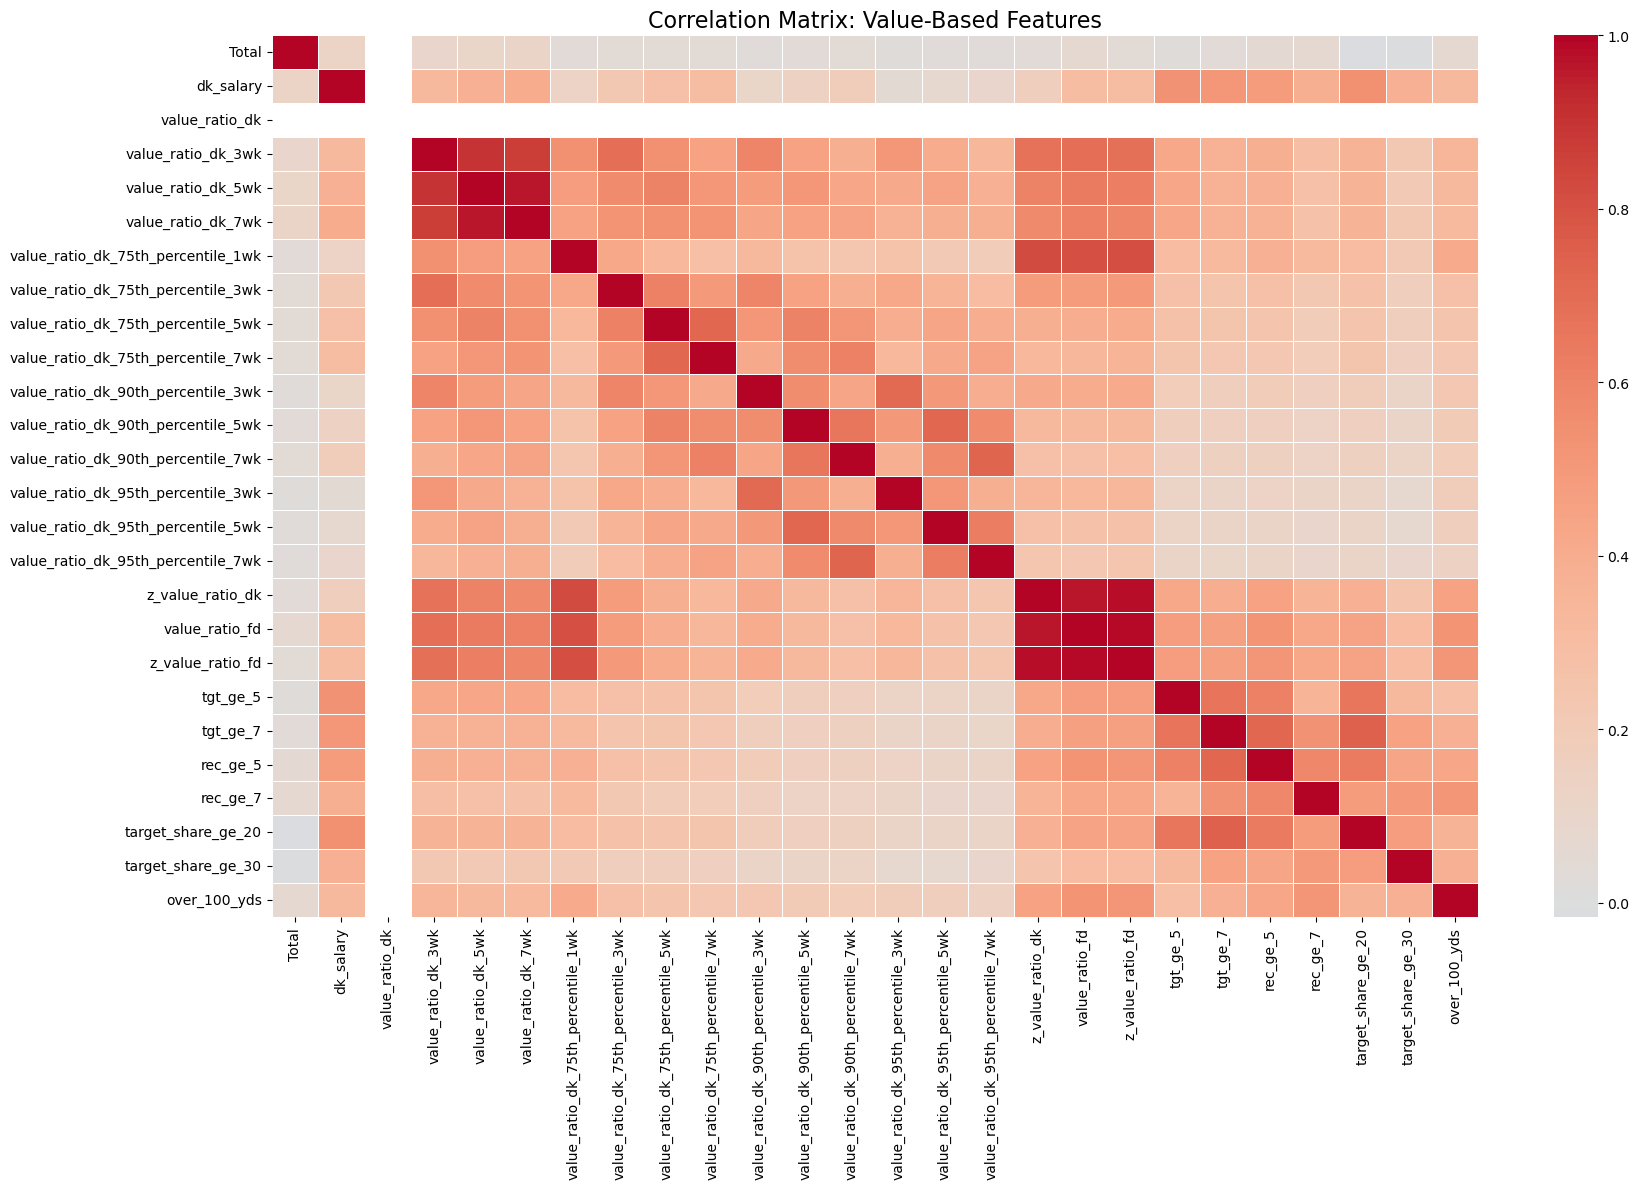

In [36]:
# Construct feature matrix and target vector
X_value = wr_df_updated[value_based_features].copy()
y_value = wr_df_updated['hit_value_dk'].copy()

# Drop rows with missing values
X_value_clean = X_value.dropna()

# Drop non-numeric column(s) for correlation only
X_corr = X_value_clean.drop(columns=['O_U'])

# Compute correlation matrix
corr_matrix = X_corr.corr()

# Plot correlation heatmap
plt.figure(figsize=(18, 12))
sns.heatmap(
    corr_matrix,
    annot=False,
    cmap='coolwarm',
    center=0,
    linewidths=0.5
)
plt.title("Correlation Matrix: Value-Based Features", fontsize=16)
plt.tight_layout()
plt.show()


In [37]:
# upated feature list

# Define cleaned value-based feature list for modeling
value_based_features = [
    'Total', 'dk_salary',
    'value_ratio_dk', 'value_ratio_dk_3wk', 'value_ratio_dk_5wk', 'value_ratio_dk_7wk',
    'value_ratio_dk_90th_percentile_3wk', 'value_ratio_dk_90th_percentile_5wk',
    'value_ratio_dk_90th_percentile_7wk',
    'z_value_ratio_dk'
]


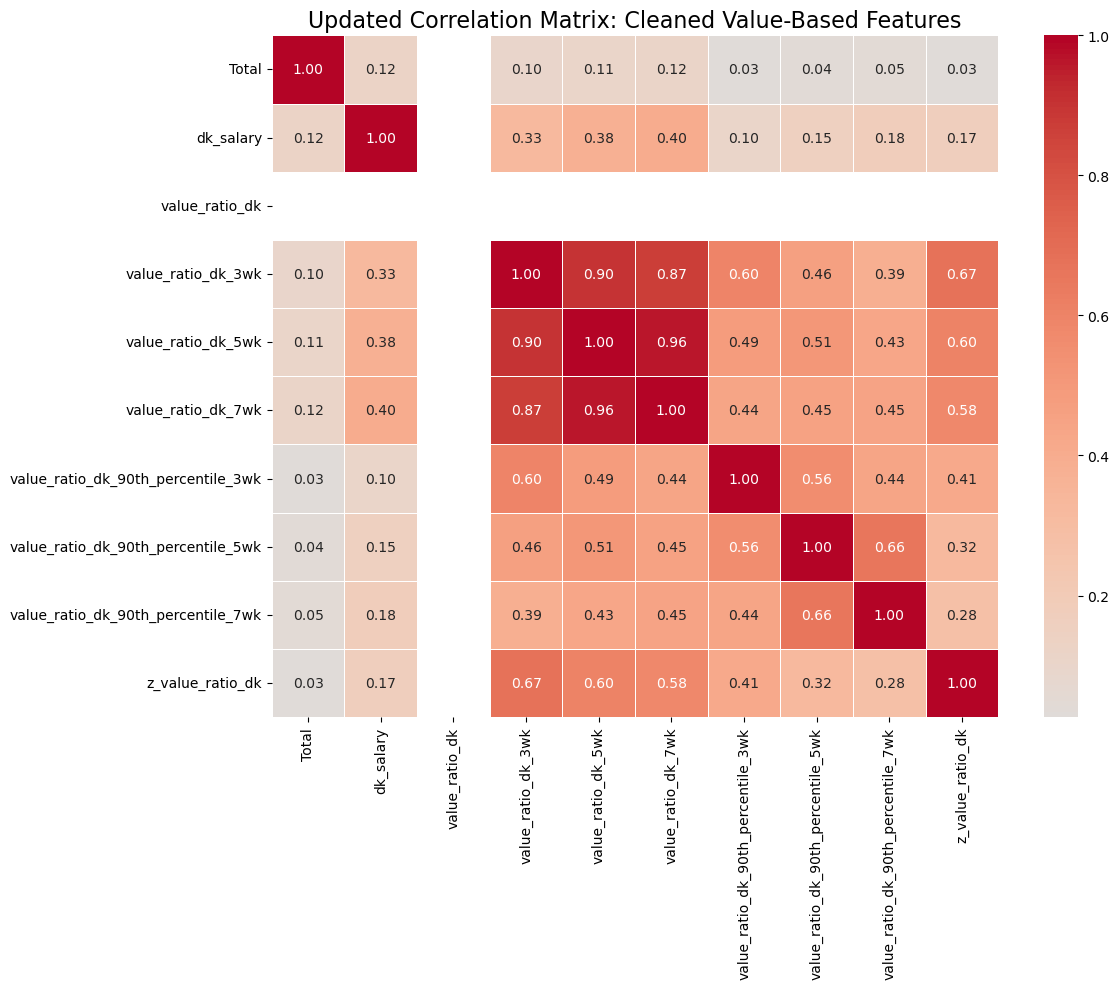

In [38]:

# Construct X and y
X_value = wr_df_updated[value_based_features].copy()
y_value = wr_df_updated['hit_value_dk'].copy()

# Drop rows with missing values for correlation matrix
X_value_clean = X_value.dropna()

# Compute and plot the updated correlation matrix
corr_matrix_updated = X_value_clean.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix_updated,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    linewidths=0.5
)
plt.title("Updated Correlation Matrix: Cleaned Value-Based Features", fontsize=16)
plt.tight_layout()
plt.show()


In [39]:
# Get the shape of the train, validate, test data

# Extract feature matrix and target vector
X_all = wr_df_updated[value_based_features].copy()
y_all = wr_df_updated['hit_value_dk'].copy()

# Include the season column to guide the split
season_series = wr_df_updated['season']

# Drop rows with missing values in X
X_all_clean = X_all.dropna()
y_all_clean = y_all.loc[X_all_clean.index]
season_clean = season_series.loc[X_all_clean.index]

# Create masks for each dataset
train_mask = season_clean < 2023
val_mask = season_clean == 2023
test_mask = season_clean == 2024

# Apply the masks
X_train = X_all_clean[train_mask]
y_train = y_all_clean[train_mask]

X_val = X_all_clean[val_mask]
y_val = y_all_clean[val_mask]

X_test = X_all_clean[test_mask]
y_test = y_all_clean[test_mask]

# Return the shapes of each split to confirm
X_train.shape, X_val.shape, X_test.shape


((10699, 10), (2059, 10), (1858, 10))

In [40]:
# train the model

# Initialize and fit logistic regression model on training data only
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Output training set score (accuracy) for quick verification
train_accuracy = model.score(X_train, y_train)
train_accuracy


0.9643891952518927

In [41]:
# feature impportance
# Extract feature names and coefficients
coefficients = pd.Series(model.coef_[0], index=X_train.columns)

# Sort by absolute value for importance
coeff_sorted = coefficients.reindex(coefficients.abs().sort_values(ascending=False).index)

coeff_sorted


z_value_ratio_dk                      13.300964
value_ratio_dk_90th_percentile_3wk    -1.047563
value_ratio_dk_3wk                     0.664925
value_ratio_dk_90th_percentile_7wk    -0.290415
value_ratio_dk_5wk                     0.243711
value_ratio_dk_90th_percentile_5wk    -0.082579
value_ratio_dk_7wk                    -0.074263
Total                                  0.047151
dk_salary                             -0.000098
value_ratio_dk                         0.000000
dtype: float64

In [42]:
# updated features

# Remove 'z_value_ratio_dk' from the feature list
features_no_zscore = [
    'Total', 'dk_salary',
    'value_ratio_dk', 'value_ratio_dk_3wk', 'value_ratio_dk_5wk', 'value_ratio_dk_7wk',
    'value_ratio_dk_90th_percentile_3wk', 'value_ratio_dk_90th_percentile_5wk',
    'value_ratio_dk_90th_percentile_7wk'
]

# Create new training feature matrix
X_train_nz = X_train[features_no_zscore]
X_val_nz = X_val[features_no_zscore]

# Refit logistic regression model
model_nz = LogisticRegression(max_iter=1000)
model_nz.fit(X_train_nz, y_train)

# Extract and sort coefficients again
coefficients_nz = pd.Series(model_nz.coef_[0], index=X_train_nz.columns)
coeff_sorted_nz = coefficients_nz.reindex(coefficients_nz.abs().sort_values(ascending=False).index)

coeff_sorted_nz


value_ratio_dk_3wk                    2.165543
value_ratio_dk_90th_percentile_3wk   -1.167253
value_ratio_dk_90th_percentile_5wk   -0.266259
value_ratio_dk_7wk                    0.192086
value_ratio_dk_5wk                    0.132191
value_ratio_dk_90th_percentile_7wk   -0.086242
Total                                -0.015381
dk_salary                             0.000006
value_ratio_dk                        0.000000
dtype: float64

In [43]:
# Define final feature list excluding dk_salary and value_ratio_dk
features_cleaned = [
    'Total',
    'value_ratio_dk_3wk', 'value_ratio_dk_5wk', 'value_ratio_dk_7wk',
    'value_ratio_dk_90th_percentile_3wk', 'value_ratio_dk_90th_percentile_5wk',
    'value_ratio_dk_90th_percentile_7wk'
]

# Extract cleaned X and y
X_all = wr_df_updated[features_cleaned].copy()
y_all = wr_df_updated['hit_value_dk'].copy()
season_series = wr_df_updated['season']

# Drop NaNs
X_all_clean = X_all.dropna()
y_all_clean = y_all.loc[X_all_clean.index]
season_clean = season_series.loc[X_all_clean.index]

# Create season-based splits
train_mask = season_clean < 2023
val_mask = season_clean == 2023

X_train = X_all_clean[train_mask]
y_train = y_all_clean[train_mask]

X_val = X_all_clean[val_mask]
y_val = y_all_clean[val_mask]

# Fit model on updated training set
model_cleaned = LogisticRegression(max_iter=1000)
model_cleaned.fit(X_train, y_train)

# Predict and evaluate on 2023 validation set
y_val_pred = model_cleaned.predict(X_val)
y_val_prob = model_cleaned.predict_proba(X_val)[:, 1]


val_report = classification_report(y_val, y_val_pred, output_dict=True)
val_roc_auc = roc_auc_score(y_val, y_val_prob)

val_report, val_roc_auc


({'False': {'precision': 0.7764198418404026,
   'recall': 0.833976833976834,
   'f1-score': 0.8041697691734921,
   'support': 1295.0},
  'True': {'precision': 0.7156084656084656,
   'recall': 0.6349765258215962,
   'f1-score': 0.6728855721393034,
   'support': 852.0},
  'accuracy': 0.7550069864927806,
  'macro avg': {'precision': 0.746014153724434,
   'recall': 0.7344766798992151,
   'f1-score': 0.7385276706563978,
   'support': 2147.0},
  'weighted avg': {'precision': 0.7522878937502253,
   'recall': 0.7550069864927806,
   'f1-score': 0.7520718949894545,
   'support': 2147.0}},
 0.828998767379049)

In [44]:
# Format the classification report dictionary for better readability
def format_classification_report(report_dict, auc_score):
    # Extract main classes
    rows = []
    for label in ['False', 'True', 'accuracy', 'macro avg', 'weighted avg']:
        if label == 'accuracy':
            rows.append(['accuracy', '', '', f"{report_dict['accuracy']:.3f}", ''])
        else:
            row = report_dict[label]
            rows.append([
                label,
                f"{row['precision']:.3f}",
                f"{row['recall']:.3f}",
                f"{row['f1-score']:.3f}",
                f"{row['support']:.0f}"
            ])
    # Append AUC
    rows.append(['roc_auc', '', '', f"{auc_score:.3f}", ''])

    # Create a DataFrame for display
    return pd.DataFrame(rows, columns=['Metric', 'Precision', 'Recall', 'F1-Score', 'Support'])

# Apply formatting
formatted_val_report = format_classification_report(val_report, val_roc_auc)
formatted_val_report


,Metric,Precision,Recall,F1-Score,Support
0,False,0.776,0.834,0.804,1295
1,True,0.716,0.635,0.673,852
2,accuracy,,,0.755,
3,macro avg,0.746,0.734,0.739,2147
4,weighted avg,0.752,0.755,0.752,2147
5,roc_auc,,,0.829,


In [45]:
from sklearn.metrics import classification_report, roc_auc_score

# Apply the same cleaned feature set to 2024 test data
test_mask = season_clean == 2024
X_test = X_all_clean[test_mask]
y_test = y_all_clean[test_mask]

# Predict and evaluate on 2024 test set
y_test_pred = model_cleaned.predict(X_test)
y_test_prob = model_cleaned.predict_proba(X_test)[:, 1]

# Compute evaluation metrics
test_report = classification_report(y_test, y_test_pred, output_dict=True)
test_roc_auc = roc_auc_score(y_test, y_test_prob)

# Format the output
def format_classification_report(report_dict, auc_score):
    rows = []
    for label in ['False', 'True', 'accuracy', 'macro avg', 'weighted avg']:
        if label == 'accuracy':
            rows.append(['accuracy', '', '', f"{report_dict['accuracy']:.3f}", ''])
        else:
            row = report_dict[label]
            rows.append([
                label,
                f"{row['precision']:.3f}",
                f"{row['recall']:.3f}",
                f"{row['f1-score']:.3f}",
                f"{row['support']:.0f}"
            ])
    rows.append(['roc_auc', '', '', f"{auc_score:.3f}", ''])
    return pd.DataFrame(rows, columns=['Metric', 'Precision', 'Recall', 'F1-Score', 'Support'])

formatted_test_report = format_classification_report(test_report, test_roc_auc)
formatted_test_report


,Metric,Precision,Recall,F1-Score,Support
0,False,0.749,0.838,0.791,1176
1,True,0.701,0.575,0.632,776
2,accuracy,,,0.734,
3,macro avg,0.725,0.707,0.712,1952
4,weighted avg,0.730,0.734,0.728,1952
5,roc_auc,,,0.835,


In [46]:
# Create a PDF summary of training, validation, and test results
class ModelSummaryPDF(FPDF):
    def header(self):
        self.set_font("Arial", "B", 14)
        self.cell(0, 10, "WR Hit Value Classification Model Summary", ln=True, align="C")
        self.ln(5)

    def add_section(self, title, dataframe):
        self.set_font("Arial", "B", 12)
        self.cell(0, 10, title, ln=True)
        self.set_font("Arial", "", 10)
        self.ln(2)
        col_widths = [30, 25, 25, 25, 25]
        for i, col in enumerate(dataframe.columns):
            self.cell(col_widths[i], 8, col, border=1)
        self.ln()
        for _, row in dataframe.iterrows():
            for i, item in enumerate(row):
                self.cell(col_widths[i], 8, str(item), border=1)
            self.ln()
        self.ln(5)

# Format 2023 and 2024 reports again using the existing function
formatted_val_report = format_classification_report(val_report, val_roc_auc)
formatted_test_report = format_classification_report(test_report, test_roc_auc)

# Create and populate PDF
pdf = ModelSummaryPDF()
pdf.add_page()
pdf.add_section("Validation Set (2023)", formatted_val_report)
pdf.add_section("Test Set (2024)", formatted_test_report)

# Save PDF
pdf_output_path = "wr_value_model_summary.pdf"
pdf.output(pdf_output_path)

pdf_output_path


'wr_value_model_summary.pdf'

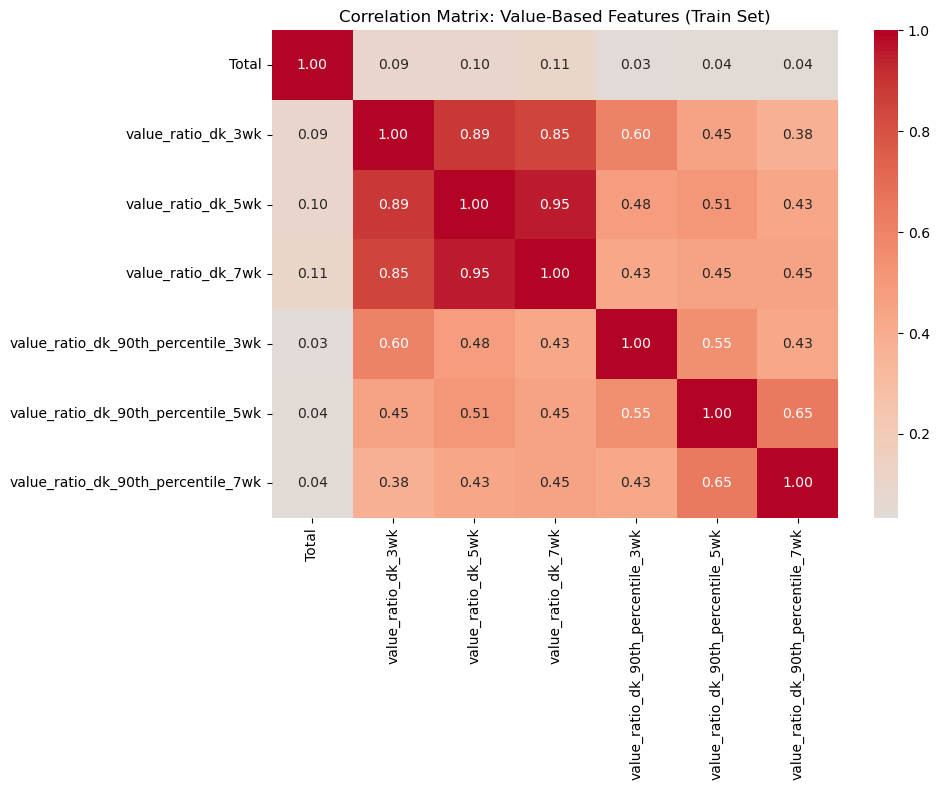

Validation Report (2023):
      Metric Precision Recall F1-Score Support
       False     0.776  0.834    0.804    1295
        True     0.716  0.635    0.673     852
    accuracy                     0.755        
   macro avg     0.746  0.734    0.739    2147
weighted avg     0.752  0.755    0.752    2147
     roc_auc                     0.829        

Test Report (2024):
      Metric Precision Recall F1-Score Support
       False     0.749  0.838    0.791    1176
        True     0.701  0.575    0.632     776
    accuracy                     0.734        
   macro avg     0.725  0.707    0.712    1952
weighted avg     0.730  0.734    0.728    1952
     roc_auc                     0.835        


In [47]:
# *** Value-based salary model: fully validated, documented, and reproducible  ***
# --- Imports ---
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Load and define features ---
df = pd.read_csv("wr_nfl_df_sorted_new_features_final.csv")

value_based_features = [
    'Total',
    'value_ratio_dk_3wk', 'value_ratio_dk_5wk', 'value_ratio_dk_7wk',
    'value_ratio_dk_90th_percentile_3wk', 'value_ratio_dk_90th_percentile_5wk',
    'value_ratio_dk_90th_percentile_7wk'
]

X_all = df[value_based_features].copy()
y_all = df['hit_value_dk'].copy()
season = df['season']

# --- Step 2: Drop rows with missing values ---
X_all_clean = X_all.dropna()
y_all_clean = y_all.loc[X_all_clean.index]
season_clean = season.loc[X_all_clean.index]

# --- Step 3: Create season-based splits ---
train_mask = season_clean < 2023
val_mask = season_clean == 2023
test_mask = season_clean == 2024

X_train = X_all_clean[train_mask]
y_train = y_all_clean[train_mask]

X_val = X_all_clean[val_mask]
y_val = y_all_clean[val_mask]

X_test = X_all_clean[test_mask]
y_test = y_all_clean[test_mask]

# --- Step 4: Fit model on training data ---
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# --- Step 5: Evaluate on validation set ---
y_val_pred = model.predict(X_val)
y_val_prob = model.predict_proba(X_val)[:, 1]

val_report = classification_report(y_val, y_val_pred, output_dict=True)
val_roc_auc = roc_auc_score(y_val, y_val_prob)

# --- Step 6: Evaluate on test set ---
y_test_pred = model.predict(X_test)
y_test_prob = model.predict_proba(X_test)[:, 1]

test_report = classification_report(y_test, y_test_pred, output_dict=True)
test_roc_auc = roc_auc_score(y_test, y_test_prob)

# --- Step 7: Format reports (optional) ---
def format_classification_report(report_dict, auc_score):
    rows = []
    for label in ['False', 'True', 'accuracy', 'macro avg', 'weighted avg']:
        if label == 'accuracy':
            rows.append(['accuracy', '', '', f"{report_dict['accuracy']:.3f}", ''])
        else:
            row = report_dict[label]
            rows.append([
                label,
                f"{row['precision']:.3f}",
                f"{row['recall']:.3f}",
                f"{row['f1-score']:.3f}",
                f"{row['support']:.0f}"
            ])
    rows.append(['roc_auc', '', '', f"{auc_score:.3f}", ''])
    return pd.DataFrame(rows, columns=['Metric', 'Precision', 'Recall', 'F1-Score', 'Support'])

val_report_df = format_classification_report(val_report, val_roc_auc)
test_report_df = format_classification_report(test_report, test_roc_auc)

# --- Step 8: Optional: Plot correlation matrix ---
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr(), annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation Matrix: Value-Based Features (Train Set)")
plt.tight_layout()
plt.show()

# --- Output reports ---
print("Validation Report (2023):")
print(val_report_df.to_string(index=False))

print("\nTest Report (2024):")
print(test_report_df.to_string(index=False))


In [48]:
### End: value-based logistic regression classifier model ###

In [49]:
### Begin: performance-based logistic regression classifier models ###

In [50]:
#

# Load the dataset
df = pd.read_csv("wr_nfl_df_sorted_new_features_final.csv")

# Get full column list
all_columns = df.columns.tolist()

# Display columns that contain 'rec_', 'tgt_', 'rec_yds_', or 'rec_air_yards_'
performance_raw_like = sorted([
    col for col in all_columns
    if col.startswith(('rec_', 'tgt_', 'rec_yds_', 'rec_air_yards_'))
])

# view list (optional)
# performance_raw_like


In [51]:
# Define inclusion criteria for safe performance-based features
include_keywords = ['_avg', '_lag_', '_delta', '_z', '_percentile']
exclude_keywords = ['fpts', 'hit_', 'value_', 'salary', 'position', 'over_', 'ge_', 'rec_touchdowns', 'Total', 'O_U']

# Build candidate feature list
initial_perf_features = [
    col for col in df.columns
    if any(kw in col for kw in include_keywords)
    and not any(kw in col for kw in exclude_keywords)
]

# Sort alphabetically for review
initial_perf_features = sorted(initial_perf_features)

# view list
# initial_perf_features


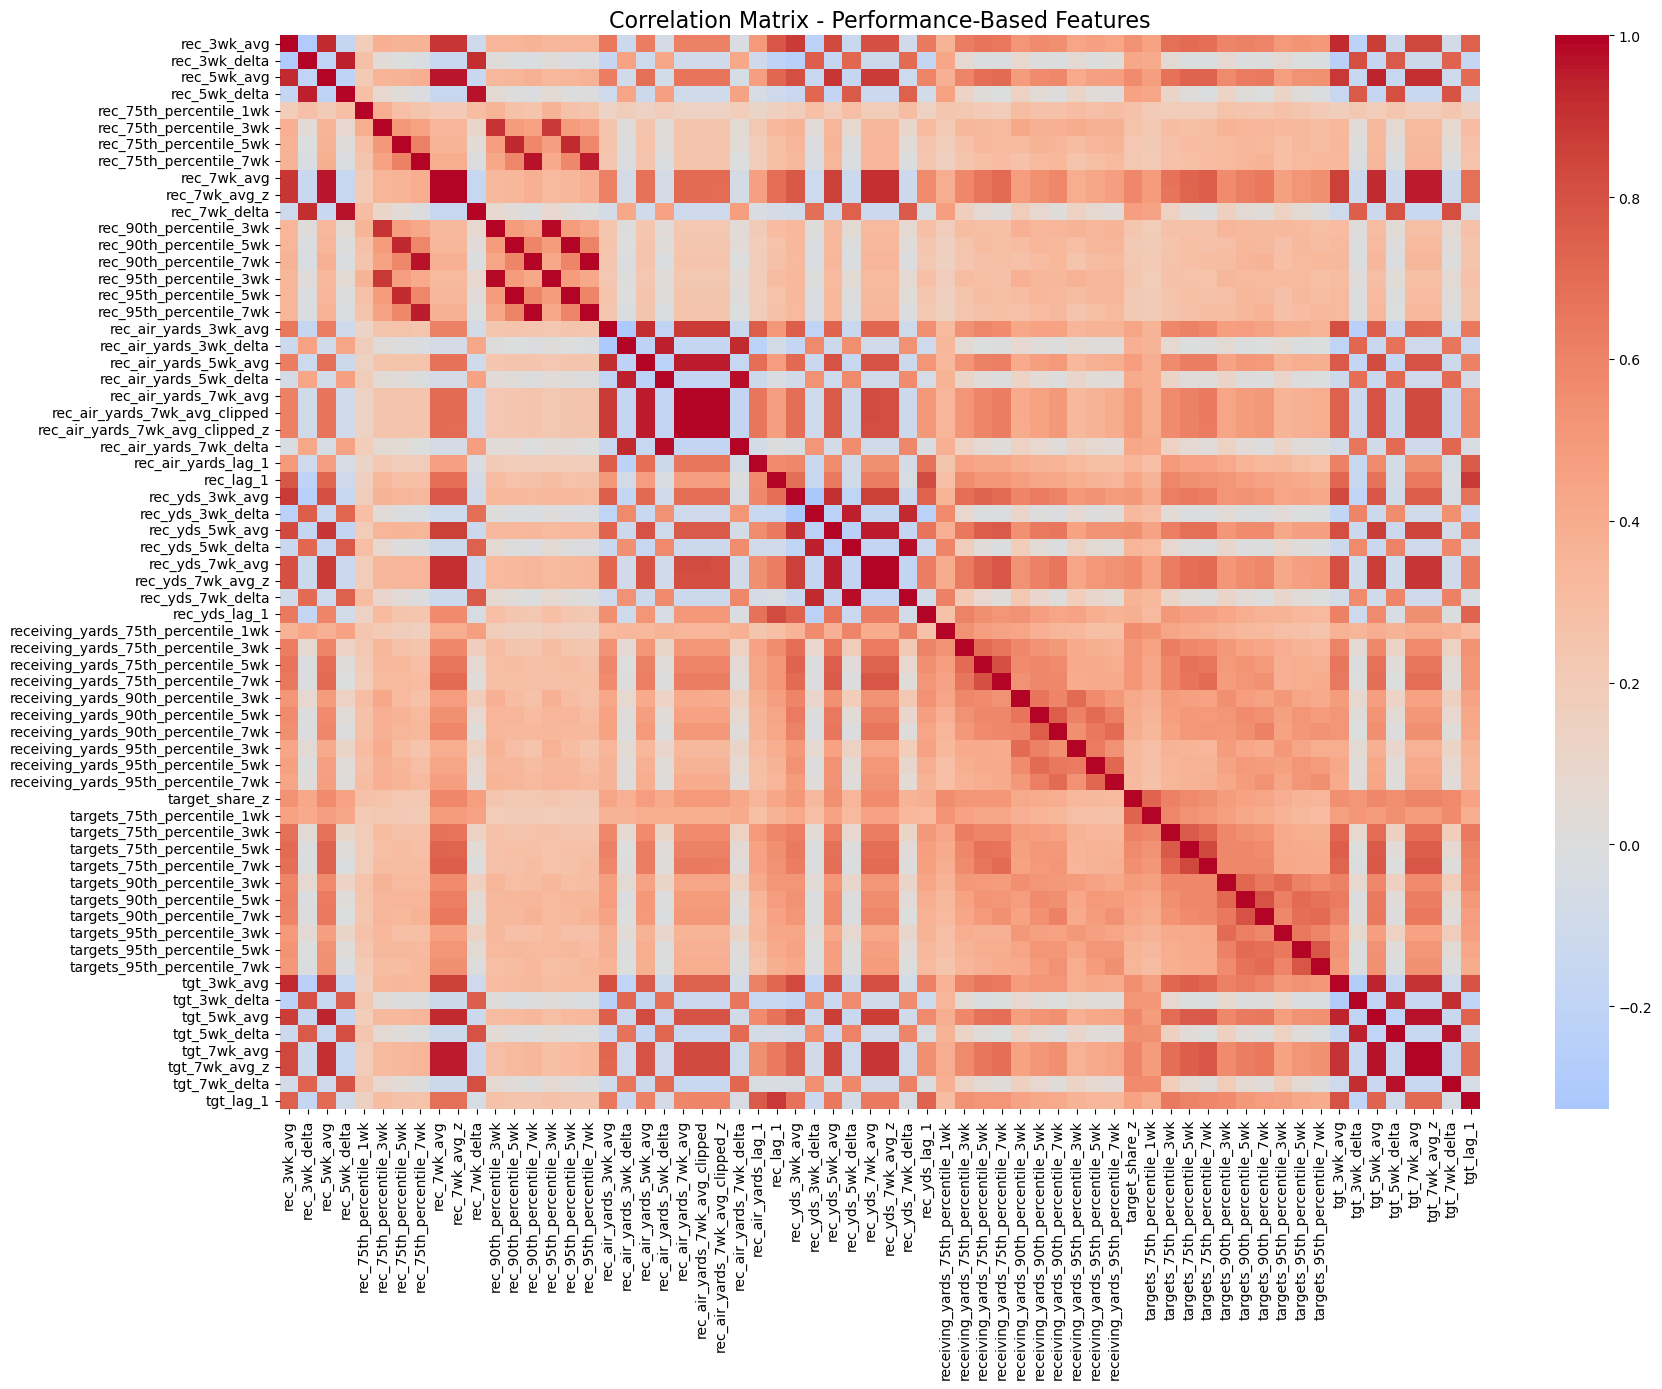

In [52]:
# Subset the dataframe using the selected features
X_perf = df[initial_perf_features].copy()

# Drop rows with missing values
X_perf_clean = X_perf.dropna()

# Compute correlation matrix
corr_matrix = X_perf_clean.corr()

# Plot correlation heatmap
plt.figure(figsize=(18, 14))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title("Correlation Matrix - Performance-Based Features", fontsize=16)
plt.tight_layout()
plt.show()


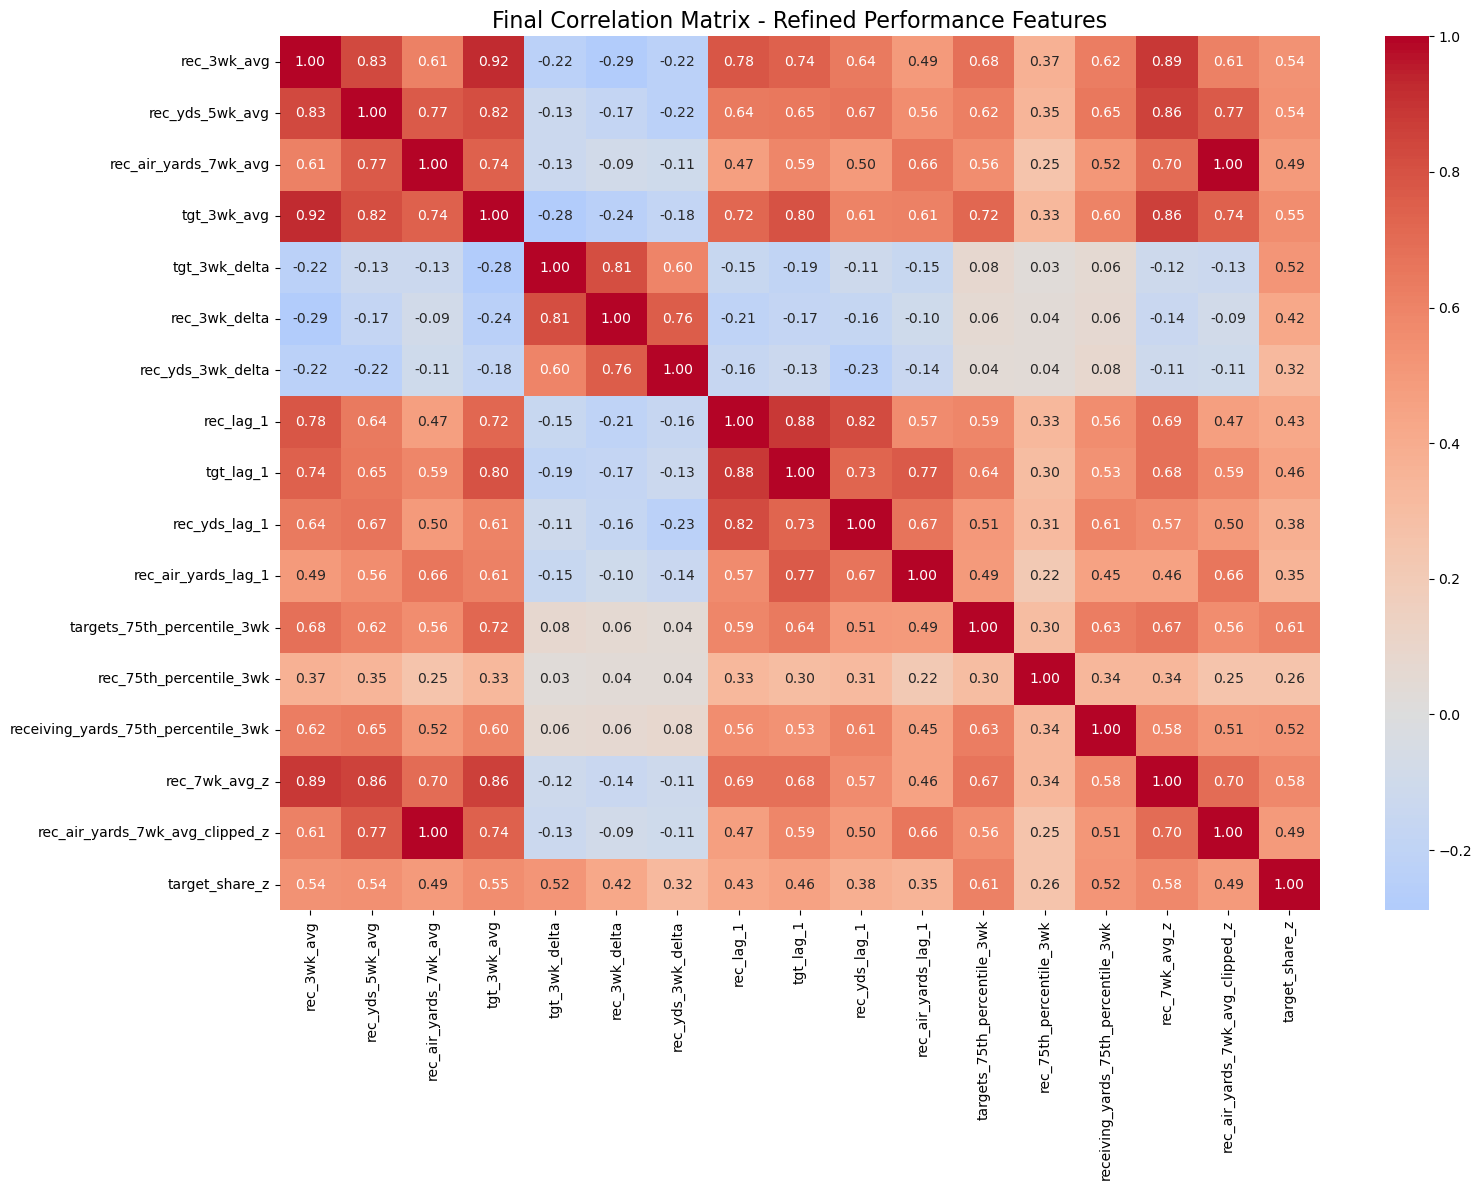

In [53]:
# Final approved feature list
performance_features = [
    'rec_3wk_avg', 'rec_yds_5wk_avg', 'rec_air_yards_7wk_avg', 'tgt_3wk_avg',
    'tgt_3wk_delta', 'rec_3wk_delta', 'rec_yds_3wk_delta',
    'rec_lag_1', 'tgt_lag_1', 'rec_yds_lag_1', 'rec_air_yards_lag_1',
    'targets_75th_percentile_3wk', 'rec_75th_percentile_3wk', 'receiving_yards_75th_percentile_3wk',
    'rec_7wk_avg_z', 'rec_air_yards_7wk_avg_clipped_z', 'target_share_z'
]

# Subset and drop NA for clean correlation
X_perf_refined = df[performance_features].dropna()

# Correlation matrix
corr_matrix_final = X_perf_refined.corr()

# Plot
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix_final, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Final Correlation Matrix - Refined Performance Features", fontsize=16)
plt.tight_layout()
plt.show()


In [54]:
# performance-based model using fpts>= a defined threshold
# view the shape of the training, validation, and test sets

# Step 1: Define the fixed threshold target
fpts_threshold = 10
df['hit_perf_fixed'] = (df['fpts'] >= fpts_threshold).astype(int)

# Step 2: Prepare feature matrix (X) and target vector (y)
X = df[performance_features].copy()
y = df['hit_perf_fixed'].copy()

# Step 3: Add season column for splitting
df_season = df[['season']].copy()
X['season'] = df_season
y.index = df_season.index  # Align indices

# Step 4: Apply train/validate/test split by season
X_train = X[X['season'] < 2023].drop(columns='season')
y_train = y[X['season'] < 2023]

X_val = X[X['season'] == 2023].drop(columns='season')
y_val = y[X['season'] == 2023]

X_test = X[X['season'] == 2024].drop(columns='season')
y_test = y[X['season'] == 2024]

# Confirm shape
(X_train.shape, y_train.shape), (X_val.shape, y_val.shape), (X_test.shape, y_test.shape)


(((12855, 17), (12855,)), ((2381, 17), (2381,)), ((2213, 17), (2213,)))

In [55]:
# performance-based model using fpts>= a defined threshold
# train the model - feature analysis

# Drop missing values from training set only
X_train_clean = X_train.dropna()
y_train_clean = y_train.loc[X_train_clean.index]

# Fit logistic regression on cleaned training set
logreg_perf = LogisticRegression(max_iter=1000, solver='liblinear')
logreg_perf.fit(X_train_clean, y_train_clean)

# Get and display feature importances
coefficients = pd.Series(logreg_perf.coef_[0], index=X_train_clean.columns).sort_values(key=abs, ascending=False)
coefficients


rec_air_yards_7wk_avg_clipped_z        1.904882
rec_7wk_avg_z                         -0.527782
receiving_yards_75th_percentile_3wk    0.452498
rec_3wk_avg                            0.450774
rec_75th_percentile_3wk                0.420859
target_share_z                         0.372202
rec_3wk_delta                          0.173301
tgt_3wk_delta                         -0.135923
rec_lag_1                             -0.066709
tgt_3wk_avg                           -0.061214
rec_air_yards_7wk_avg                 -0.060225
rec_yds_3wk_delta                      0.040047
targets_75th_percentile_3wk           -0.036682
rec_yds_5wk_avg                        0.027401
tgt_lag_1                             -0.022484
rec_yds_lag_1                          0.005198
rec_air_yards_lag_1                    0.000630
dtype: float64

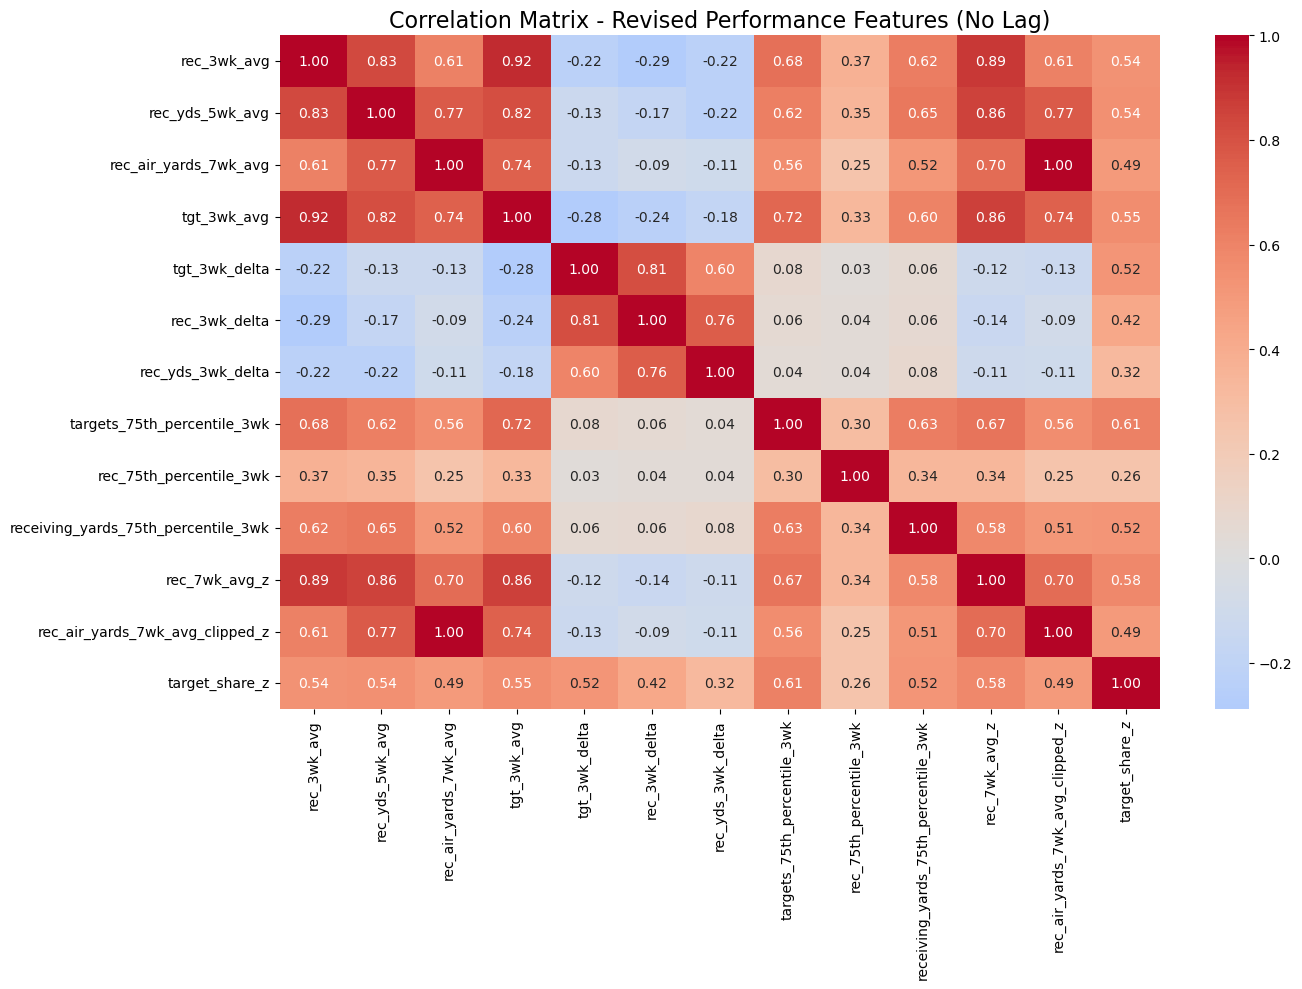

In [56]:
# performance-based model using fpts>= a defined threshold
# Revise the features list based on results
# Step 1: Define revised feature list (remove lag features)
performance_features_revised = [
    'rec_3wk_avg', 'rec_yds_5wk_avg', 'rec_air_yards_7wk_avg', 'tgt_3wk_avg',
    'tgt_3wk_delta', 'rec_3wk_delta', 'rec_yds_3wk_delta',
    'targets_75th_percentile_3wk', 'rec_75th_percentile_3wk', 'receiving_yards_75th_percentile_3wk',
    'rec_7wk_avg_z', 'rec_air_yards_7wk_avg_clipped_z', 'target_share_z'
]

# Step 2: Subset data and drop NAs for correlation
X_perf_revised = df[performance_features_revised].dropna()

# Step 3: Compute and display correlation matrix
corr_matrix_revised = X_perf_revised.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix_revised, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation Matrix - Revised Performance Features (No Lag)", fontsize=16)
plt.tight_layout()
plt.show()


In [57]:
# performance-based model using fpts>= a defined threshold
# Step 4: Prepare revised feature matrix (X) and target vector (y)
X = df[performance_features_revised].copy()
y = df['hit_perf_fixed'].copy()

# Add season column for splitting
X['season'] = df['season']
y.index = df.index

# Apply train/val/test split by season
X_train = X[X['season'] < 2023].drop(columns='season')
y_train = y[X['season'] < 2023]

X_val = X[X['season'] == 2023].drop(columns='season')
y_val = y[X['season'] == 2023]

X_test = X[X['season'] == 2024].drop(columns='season')
y_test = y[X['season'] == 2024]

# Drop missing values in training set
X_train_clean = X_train.dropna()
y_train_clean = y_train.loc[X_train_clean.index]

# Check shapes after dropping NA
X_train_clean.shape, y_train_clean.shape


((5347, 13), (5347,))

In [58]:
# performance-based model using fpts>= a defined threshold
# Retrain logistic regression with revised feature set
logreg_perf_revised = LogisticRegression(max_iter=1000, solver='liblinear')
logreg_perf_revised.fit(X_train_clean, y_train_clean)

# Display sorted coefficients
coefficients_revised = pd.Series(
    logreg_perf_revised.coef_[0], index=X_train_clean.columns
).sort_values(key=abs, ascending=False)

coefficients_revised


rec_air_yards_7wk_avg_clipped_z        1.947604
rec_7wk_avg_z                         -0.585278
receiving_yards_75th_percentile_3wk    0.532619
rec_75th_percentile_3wk                0.433162
rec_3wk_avg                            0.429928
target_share_z                         0.370332
rec_3wk_delta                          0.182269
tgt_3wk_delta                         -0.134289
tgt_3wk_avg                           -0.080325
targets_75th_percentile_3wk           -0.069584
rec_air_yards_7wk_avg                 -0.060624
rec_yds_3wk_delta                      0.038903
rec_yds_5wk_avg                        0.030090
dtype: float64

In [59]:
# performance-based model using fpts>= a defined threshold
# Validate the model

# Drop missing values in validation set
X_val_clean = X_val.dropna()
y_val_clean = y_val.loc[X_val_clean.index]

# Predict on validation set
y_val_pred = logreg_perf_revised.predict(X_val_clean)
y_val_proba = logreg_perf_revised.predict_proba(X_val_clean)[:, 1]

# Classification report and ROC AUC
val_report = classification_report(y_val_clean, y_val_pred, output_dict=True)
val_auc = roc_auc_score(y_val_clean, y_val_proba)

val_report, val_auc


({'0': {'precision': 0.8942307692307693,
   'recall': 0.9522184300341296,
   'f1-score': 0.9223140495867769,
   'support': 879.0},
  '1': {'precision': 0.7391304347826086,
   'recall': 0.5458715596330275,
   'f1-score': 0.6279683377308707,
   'support': 218.0},
  'accuracy': 0.8714676390154968,
  'macro avg': {'precision': 0.816680602006689,
   'recall': 0.7490449948335786,
   'f1-score': 0.7751411936588237,
   'support': 1097.0},
  'weighted avg': {'precision': 0.8634086426038787,
   'recall': 0.8714676390154968,
   'f1-score': 0.8638205535206078,
   'support': 1097.0}},
 0.9045568880399953)

In [60]:
# performance-based model using fpts>= a defined threshold
# Validate the model

# Pretty print a classification report and ROC AUC score
def print_classification_summary(report_dict, roc_auc_value):
  
    df = pd.DataFrame(report_dict).transpose().round(3)
    
    # Ensure 'support' is always an integer for readability
    if 'support' in df.columns:
        df['support'] = df['support'].astype(int)
    
    # Add ROC AUC row to the bottom
    df.loc["ROC AUC"] = ["", "", "", round(roc_auc_value, 3)]
    
    # Convert to string and print
    print(df.to_string(index=True))

print("\n--- 2023 VALIDATION RESULTS (fpts>= defined threshold ) ---")
print_classification_summary(val_report, val_auc)



--- 2023 VALIDATION RESULTS (fpts>= defined threshold ) ---
             precision recall f1-score   support
0                0.894  0.952    0.922   879.000
1                0.739  0.546    0.628   218.000
accuracy         0.871  0.871    0.871     0.000
macro avg        0.817  0.749    0.775  1097.000
weighted avg     0.863  0.871    0.864  1097.000
ROC AUC                                    0.905


In [61]:
# performance-based model using fpts>= a defined threshold
# Test the model

# Drop missing values in test set
X_test_clean = X_test.dropna()
y_test_clean = y_test.loc[X_test_clean.index]

# Predict on test set
y_test_pred = logreg_perf_revised.predict(X_test_clean)
y_test_proba = logreg_perf_revised.predict_proba(X_test_clean)[:, 1]

# Classification report and ROC AUC
test_report = classification_report(y_test_clean, y_test_pred, output_dict=True)
test_auc = roc_auc_score(y_test_clean, y_test_proba)

# Format the report for readability
test_report_df = pd.DataFrame(test_report).transpose()
test_report_df['support'] = test_report_df['support'].astype(int)
test_report_df_rounded = test_report_df.round(3)
test_report_df_rounded.loc["ROC AUC"] = ["", "", "", test_auc]

# Print readable output
# Print output
print("\n--- 2024 TEST RESULTS (fpts>= defined threshold ) ---")
print(test_report_df_rounded.to_string(index=True))
print(f"\nROC AUC: {test_auc:.3f}")



--- 2024 TEST RESULTS (fpts>= defined threshold ) ---
             precision recall f1-score     support
0                0.886  0.948    0.916  775.000000
1                0.735  0.539    0.622  206.000000
accuracy         0.862  0.862    0.862    0.000000
macro avg         0.81  0.744    0.769  981.000000
weighted avg     0.854  0.862    0.854  981.000000
ROC AUC                                   0.911594

ROC AUC: 0.912


In [62]:
print_classification_summary(test_report, test_auc)


             precision recall f1-score  support
0                0.886  0.948    0.916  775.000
1                0.735  0.539    0.622  206.000
accuracy         0.862  0.862    0.862    0.000
macro avg         0.81  0.744    0.769  981.000
weighted avg     0.854  0.862    0.854  981.000
ROC AUC                                   0.912


In [63]:
# performance-based model using a percentile-based threshold 
# create the target

# --- Define the percentile threshold for the target (adjustable) ---
performance_percentile_threshold = 0.85  # This can be changed to 0.75, 0.90, etc.

# --- Filter training data for seasons < 2023 ---
training_fpts = df[df['season'] < 2023]['fpts']

# --- Calculate the fantasy point value at the desired percentile ---
fpts_percentile_value = training_fpts.quantile(performance_percentile_threshold)

# --- Create binary target column based on this threshold ---
df['hit_perf_percentile'] = (df['fpts'] >= fpts_percentile_value).astype(int)

# --- Output the threshold value ---
fpts_percentile_value


11.5

In [64]:
# performance-based model using a percentile-based threshold 
# get the shape of the training data

# Rebuild feature matrix (X) and updated target (y) after redefining percentile target
X = df[performance_features].copy()
y = df['hit_perf_percentile'].copy()

# Add season for splitting
X['season'] = df['season']
y.index = df.index

# Train: seasons < 2023
X_train = X[X['season'] < 2023].drop(columns='season').dropna()
y_train = y.loc[X_train.index]

# Validation: season == 2023
X_val = X[X['season'] == 2023].drop(columns='season').dropna()
y_val = y.loc[X_val.index]

# Test: season == 2024
X_test = X[X['season'] == 2024].drop(columns='season').dropna()
y_test = y.loc[X_test.index]

# Display the shape of all datasets for verification
{
    "Train Features": X_train.shape,
    "Train Target": y_train.shape,
    "Validation Features": X_val.shape,
    "Validation Target": y_val.shape,
    "Test Features": X_test.shape,
    "Test Target": y_test.shape
}


{'Train Features': (5347, 17),
 'Train Target': (5347,),
 'Validation Features': (1097, 17),
 'Validation Target': (1097,),
 'Test Features': (981, 17),
 'Test Target': (981,)}

In [65]:
# performance-based model using a percentile-based threshold 
# train the model - show the features and coefficients

# Train logistic regression model on the 85th percentile target
logreg_perf_percentile = LogisticRegression(max_iter=1000, solver='liblinear')
logreg_perf_percentile.fit(X_train, y_train)

# Display coefficients for interpretability
coefficients_percentile = pd.Series(
    logreg_perf_percentile.coef_[0],
    index=X_train.columns
).sort_values(key=abs, ascending=False)

coefficients_percentile


rec_air_yards_7wk_avg_clipped_z        2.307281
receiving_yards_75th_percentile_3wk    0.675822
rec_7wk_avg_z                         -0.528501
target_share_z                         0.408688
rec_75th_percentile_3wk                0.404380
rec_3wk_avg                            0.396270
targets_75th_percentile_3wk           -0.221269
tgt_3wk_delta                         -0.118220
rec_lag_1                             -0.110399
rec_3wk_delta                          0.084278
rec_air_yards_7wk_avg                 -0.073226
tgt_3wk_avg                           -0.058932
rec_yds_3wk_delta                      0.043240
rec_yds_5wk_avg                        0.028840
tgt_lag_1                              0.024393
rec_yds_lag_1                          0.004817
rec_air_yards_lag_1                   -0.000157
dtype: float64

In [66]:
# performance-based model using a percentile-based threshold 
# validate the model

# Predict on validation set (2023)
y_val_pred = logreg_perf_percentile.predict(X_val)
y_val_proba = logreg_perf_percentile.predict_proba(X_val)[:, 1]

# Evaluate
val_report_percentile = classification_report(y_val, y_val_pred, output_dict=True)
val_auc_percentile = roc_auc_score(y_val, y_val_proba)

# Format for readable output
val_df_percentile = pd.DataFrame(val_report_percentile).transpose().round(3)
val_df_percentile['support'] = val_df_percentile['support'].astype(int)
val_df_percentile.loc["ROC AUC"] = ["", "", "", round(val_auc_percentile, 3)]

# Print output
print("\n--- 2023 VALIDATION RESULTS (85th Percentile Target) ---")
print(val_df_percentile.to_string(index=True))



--- 2023 VALIDATION RESULTS (85th Percentile Target) ---
             precision recall f1-score   support
0                0.908  0.955    0.931   921.000
1                 0.68  0.494    0.572   176.000
accuracy         0.881  0.881    0.881     0.000
macro avg        0.794  0.725    0.752  1097.000
weighted avg     0.871  0.881    0.874  1097.000
ROC AUC                                    0.911


In [67]:
print_classification_summary(val_report_percentile, val_auc_percentile)

             precision recall f1-score   support
0                0.908  0.955    0.931   921.000
1                 0.68  0.494    0.572   176.000
accuracy         0.881  0.881    0.881     0.000
macro avg        0.794  0.725    0.752  1097.000
weighted avg     0.871  0.881    0.874  1097.000
ROC AUC                                    0.911


In [68]:
# performance-based model using a percentile-based threshold 
# test the model

# Predict on 2024 test set
y_test_pred = logreg_perf_percentile.predict(X_test)
y_test_proba = logreg_perf_percentile.predict_proba(X_test)[:, 1]

# Evaluate
test_report_percentile = classification_report(y_test, y_test_pred, output_dict=True)
test_auc_percentile = roc_auc_score(y_test, y_test_proba)

# Format output
test_df_percentile = pd.DataFrame(test_report_percentile).transpose().round(3)
test_df_percentile['support'] = test_df_percentile['support'].astype(int)
test_df_percentile.loc["ROC AUC"] = ["", "", "", round(test_auc_percentile, 3)]

# Print test results
print("\n--- 2024 TEST RESULTS (85th Percentile Target) ---")
print(test_df_percentile.to_string(index=True))



--- 2024 TEST RESULTS (85th Percentile Target) ---
             precision recall f1-score  support
0                0.895  0.951    0.922  809.000
1                0.672  0.477    0.558  172.000
accuracy         0.867  0.867    0.867    0.000
macro avg        0.784  0.714     0.74  981.000
weighted avg     0.856  0.867    0.858  981.000
ROC AUC                                   0.906


In [69]:
### End: performance-based logistic regression classifier model ###

In [70]:
### Begin: Prediction Dataframes  ###

In [71]:
# --- Your helper functions ---
def get_current_week():
    current_date = datetime.now()
    season_start_date = datetime(2024, 9, 4)
    return ((current_date - season_start_date).days // 7) + 1

def get_year_range(current_year, current_week, start_year=2017):
    return list(range(start_year, current_year + 1)) if current_week <= 18 else list(range(start_year, current_year))


In [72]:
# List and print all columns from the loaded dataframe
df_columns = df.columns.tolist()

print(f"🧠 Total Columns: {len(df_columns)}\n")
for col in df_columns:
    print(col)


🧠 Total Columns: 247

season
season_type
week
name
position
recent_team
player_display_name
team_abbr_x
rost
dk_salary
fd_salary
value_ratio_dk
value_ratio_fd
value_ratio_dk_log
value_ratio_fd_log
value_ratio_dk_log_z
value_ratio_fd_log_z
fpts
pos_avg_fpts
fpts_above_pos_avg
expected_fpts_dk
fpts_diff_dk
hit_value_dk
rolling_fpts_diff_dk
z_fpts_diff_dk
z_value_ratio_dk
expected_fpts_fd
fpts_diff_fd
hit_value_fd
rolling_fpts_diff_fd
z_fpts_diff_fd
z_value_ratio_fd
double_digit_targets
boom_week
bust_week
macro_tier_score_season
macro_tier_score_missing
macro_tier_season
is_macro_high_tier
is_macro_mid_tier
is_macro_low_tier
opponent_abbr
home
role
result
score
spread
over_under
is_home_game
O_U
Total
receptions
receiving_yards
yards
receiving_yards_after_catch
targets
target_share
target_share_z
catch_percentage
catch_percentage_scaled
catch_percentage_scaled_z
avg_cushion
avg_separation
avg_yac
avg_expected_yac
avg_yac_above_expectation
receiving_broken_tackles
receiving_rat
receiving_

In [73]:
# ✅ Baseline metadata columns
baseline_cols = [
    "season", "season_type", "week", "name", "position", "recent_team",
    "player_display_name", "team_abbr_x", "rost", "dk_salary", "fd_salary"
]

# ✅ Target columns
target_cols = [
    "hit_value_dk",         # Value-based threshold
    "hit_perf_fixed",       # FPTS ≥ 10 (formerly hit_perf_fpts10)
    "hit_perf_percentile"   # Top 15% WR performance
]

# ✅ Optional display columns (for dashboard or inspection)
optional_display_cols = [
    "fpts", "value_ratio_dk", "fpts_3wk_avg", 
    "targets", "receptions", "receiving_yards", 
    "receiving_air_yards", "target_share", "catch_percentage"
]

# ✅ Feature columns for logistic regression (hit_value_dk)
feature_cols = [
    "dk_salary", "rost", "fpts_3wk_avg", "value_ratio_dk",
    "targets", "receptions", "receiving_yards", 
    "receiving_air_yards", "target_share", "catch_percentage"
]


In [74]:
# rename df to wr
wr_df = df.copy()

In [75]:
# Value-Based Prediction Dataframe

# column cleaning
for col in feature_cols:
    non_numeric = wr_df[col][~wr_df[col].apply(lambda x: isinstance(x, (int, float)))]
    if not non_numeric.empty:
        print(f"\n🚨 Column: {col}")
        print(non_numeric.unique()[:5])



🚨 Column: rost
['0.7%' '0.0%' '62.0%' '1.4%' '31.2%']


In [76]:
# Value-Based Prediction Dataframe
# column cleaning and data formatting

# Patch: recompute value_ratio_dk if missing or all zero
if df["value_ratio_dk"].sum() == 0:
    df["value_ratio_dk"] = df["fpts"] / df["dk_salary"]

# scale the ratio to get integers and not tiny decimals
df["value_ratio_dk"] = df["fpts"] / (df["dk_salary"] / 1000)
df["value_ratio_dk"] = df["value_ratio_dk"].replace([np.inf, -np.inf], np.nan)


In [77]:
# Value-Based Prediction Dataframe

# check to ensure cleaning was successful
df["value_ratio_dk"].describe()
df["value_ratio_dk"].value_counts().head()


value_ratio_dk
0.0    1354
0.5     148
0.2     128
0.3     117
1.0     111
Name: count, dtype: int64

In [78]:
## ** INPUT REQUIRED **
# add filtering option for backtest or live predictions

# filter option for backtest or live predictions
backtest_mode = True  # Set to False for in-season use

# Define current season context
current_year = datetime.now().year
current_week = get_current_week()
years = get_year_range(current_year, current_week)

# Filter the main df
if backtest_mode:
    df = df[df["season"].isin(years)].copy()
else:
    df = df[df["season"] == current_year].copy()



In [79]:
# *** Create New Dataframe: Value-Based Prediction Dataframe ***

# --- Step 1: Filter dataset ---
wr_df = wr_df[wr_df["position"] == "WR"]
wr_df = wr_df.dropna(subset=["hit_value_dk"])


# --- Step 2: Filter dataset ---
percent_cols = ["catch_percentage", "target_share", "rost"]

for col in percent_cols:
    if col in wr_df.columns:
        wr_df[col] = (
            wr_df[col]
            .astype(str)
            .str.strip()
            .str.replace('%', '', regex=False)
        )
        wr_df[col] = pd.to_numeric(wr_df[col], errors='coerce')


# ✅ Now drop rows with any remaining NA in features
wr_df = wr_df.dropna(subset=feature_cols)


X = wr_df[feature_cols].copy()
y = wr_df["hit_value_dk"]

# --- Step 3: Standardize features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Step 4: Train logistic regression ---
model = LogisticRegression(max_iter=1000)
model.fit(X_scaled, y)

# --- Step 5: Generate predictions ---
pred_probs = model.predict_proba(X_scaled)[:, 1]
pred_classes = model.predict(X_scaled)

# --- Step 6: Add predictions to dataframe ---
wr_df["pred_prob_value"] = pred_probs
wr_df["pred_class_value"] = pred_classes

# --- Step 7: Build prediction dataframe ---
prediction_df_value = wr_df[
    baseline_cols +
    target_cols[:1] +  # Only 'hit_value_dk'
    ["pred_prob_value", "pred_class_value"] +
    optional_display_cols
].copy()


In [80]:
# Quick inspection of prediction_df_value
print(f"✅ Rows: {len(prediction_df_value)} | Columns: {prediction_df_value.shape[1]}")
display(prediction_df_value.head())


✅ Rows: 5417 | Columns: 23


,season,season_type,week,name,position,recent_team,player_display_name,team_abbr_x,rost,dk_salary,...,pred_class_value,fpts,value_ratio_dk,fpts_3wk_avg,targets,receptions,receiving_yards,receiving_air_yards,target_share,catch_percentage
3,2017,REG,4,A.J. Green,WR,CIN,A.J. Green,CIN,0.7,8600.0,...,False,12.3,0.0,10.4,7,5,63.0,38.0,0.2,71.4
4,2017,REG,5,A.J. Green,WR,CIN,A.J. Green,CIN,0.7,8200.0,...,True,22.9,0.0,12.0,13,7,189.0,196.0,0.4,53.8
5,2017,REG,7,A.J. Green,WR,CIN,A.J. Green,CIN,0.7,8300.0,...,False,4.1,0.0,17.4,6,3,41.0,105.0,0.2,50.0
6,2017,REG,8,A.J. Green,WR,CIN,A.J. Green,CIN,0.7,8600.0,...,False,8.7,0.0,13.1,8,3,27.0,57.0,0.3,37.5
8,2017,REG,10,A.J. Green,WR,CIN,A.J. Green,CIN,0.7,7700.0,...,True,17.5,0.0,4.5,7,5,115.0,115.0,0.2,71.4


In [81]:
# Verify distribution of new value-based prediction dataframe ***

# Distribution of predicted probabilities
prediction_df_value["pred_prob_value"].describe()

# Value counts for predicted vs. actual
print("📊 Predicted Classes:")
print(prediction_df_value["pred_class_value"].value_counts())

print("\n🎯 Actual Outcomes (hit_value_dk):")
print(prediction_df_value["hit_value_dk"].value_counts())


📊 Predicted Classes:
pred_class_value
True     3658
False    1759
Name: count, dtype: int64

🎯 Actual Outcomes (hit_value_dk):
hit_value_dk
True     3597
False    1820
Name: count, dtype: int64


In [82]:
# *** New Dataframe: performance-based prediction dataframe fpts>= threshold ***

# --- Step 1: Filter dataset for FPTS >= 10 target ---
wr_df = df.copy()
wr_df = wr_df[wr_df["position"] == "WR"]
wr_df = wr_df.dropna(subset=["hit_perf_fixed"])

# --- Step 2: Fix percentage columns ---
percent_cols = ["catch_percentage", "target_share", "rost"]
for col in percent_cols:
    if col in wr_df.columns:
        wr_df[col] = (
            wr_df[col]
            .astype(str)
            .str.strip()
            .str.replace('%', '', regex=False)
        )
        wr_df[col] = pd.to_numeric(wr_df[col], errors='coerce')

# --- Step 3: Drop rows with missing feature values ---
wr_df = wr_df.dropna(subset=feature_cols)

# --- Step 4: Build model inputs ---
X = wr_df[feature_cols].copy()
y = wr_df["hit_perf_fixed"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = LogisticRegression(max_iter=1000)
model.fit(X_scaled, y)

# --- Step 5: Predictions ---
wr_df["pred_prob_fpts10"] = model.predict_proba(X_scaled)[:, 1]
wr_df["pred_class_fpts10"] = model.predict(X_scaled)

# --- Step 6: Build prediction dataframe ---
prediction_df_fpts10 = wr_df[
    baseline_cols +
    target_cols[1:2] +  # Only 'hit_perf_fixed'
    ["pred_prob_fpts10", "pred_class_fpts10"] +
    optional_display_cols
].copy()


In [83]:
# performance-based prediction dataframe fpts>= threshold 
# check the distribution and df

# Size and preview
print(f"✅ Rows: {len(prediction_df_fpts10)} | Columns: {prediction_df_fpts10.shape[1]}")
display(prediction_df_fpts10.head())

# Distribution of predicted classes
print("\n📊 Predicted Classes (FPTS10):")
print(prediction_df_fpts10["pred_class_fpts10"].value_counts())

# Distribution of actual outcomes
print("\n🎯 Actual Outcomes (hit_perf_fixed):")
print(prediction_df_fpts10["hit_perf_fixed"].value_counts())

# Optional: Look at prediction probabilities
print("\n📈 Probability Distribution:")
print(prediction_df_fpts10["pred_prob_fpts10"].describe())


✅ Rows: 5417 | Columns: 23


,season,season_type,week,name,position,recent_team,player_display_name,team_abbr_x,rost,dk_salary,...,pred_class_fpts10,fpts,value_ratio_dk,fpts_3wk_avg,targets,receptions,receiving_yards,receiving_air_yards,target_share,catch_percentage
3,2017,REG,4,A.J. Green,WR,CIN,A.J. Green,CIN,0.7,8600.0,...,1,12.3,1.430233,10.4,7,5,63.0,38.0,0.2,71.4
4,2017,REG,5,A.J. Green,WR,CIN,A.J. Green,CIN,0.7,8200.0,...,1,22.9,2.792683,12.0,13,7,189.0,196.0,0.4,53.8
5,2017,REG,7,A.J. Green,WR,CIN,A.J. Green,CIN,0.7,8300.0,...,0,4.1,0.493976,17.4,6,3,41.0,105.0,0.2,50.0
6,2017,REG,8,A.J. Green,WR,CIN,A.J. Green,CIN,0.7,8600.0,...,0,8.7,1.011628,13.1,8,3,27.0,57.0,0.3,37.5
8,2017,REG,10,A.J. Green,WR,CIN,A.J. Green,CIN,0.7,7700.0,...,1,17.5,2.272727,4.5,7,5,115.0,115.0,0.2,71.4



📊 Predicted Classes (FPTS10):
pred_class_fpts10
0    3527
1    1890
Name: count, dtype: int64

🎯 Actual Outcomes (hit_perf_fixed):
hit_perf_fixed
0    3516
1    1901
Name: count, dtype: int64

📈 Probability Distribution:
count    5.417000e+03
mean     3.509205e-01
std      4.421515e-01
min      6.735585e-14
25%      2.765137e-05
50%      1.124293e-02
75%      9.626950e-01
max      1.000000e+00
Name: pred_prob_fpts10, dtype: float64


In [84]:
# *** New Dataframe: performance-based prediction dataframe percentage>= threshold ***
# --- Step 1: Filter dataset for 85th percentile target ---
wr_df = df.copy()
wr_df = wr_df[wr_df["position"] == "WR"]
wr_df = wr_df.dropna(subset=["hit_perf_percentile"])

# --- Step 2: Fix percentage columns ---
percent_cols = ["catch_percentage", "target_share", "rost"]
for col in percent_cols:
    if col in wr_df.columns:
        wr_df[col] = (
            wr_df[col]
            .astype(str)
            .str.strip()
            .str.replace('%', '', regex=False)
        )
        wr_df[col] = pd.to_numeric(wr_df[col], errors='coerce')

# --- Step 3: Drop NA in features ---
wr_df = wr_df.dropna(subset=feature_cols)

# --- Step 4: Prepare model inputs ---
X = wr_df[feature_cols].copy()
y = wr_df["hit_perf_percentile"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = LogisticRegression(max_iter=1000)
model.fit(X_scaled, y)

# --- Step 5: Predictions ---
wr_df["pred_prob_85pct"] = model.predict_proba(X_scaled)[:, 1]
wr_df["pred_class_85pct"] = model.predict(X_scaled)

# --- Step 6: Build prediction dataframe ---
prediction_df_85pct = wr_df[
    baseline_cols +
    target_cols[2:] +  # Only 'hit_perf_percentile'
    ["pred_prob_85pct", "pred_class_85pct"] +
    optional_display_cols
].copy()


In [85]:
# performance-based prediction dataframe percentage>= threshold 
# check the distribution and df
# ✅ Basic preview
print(f"✅ Rows: {len(prediction_df_85pct)} | Columns: {prediction_df_85pct.shape[1]}")
display(prediction_df_85pct.head())

# 📊 Predicted class distribution
print("\n📊 Predicted Classes (85th Percentile):")
print(prediction_df_85pct["pred_class_85pct"].value_counts())

# 🎯 Actual class distribution
print("\n🎯 Actual Outcomes (hit_perf_percentile):")
print(prediction_df_85pct["hit_perf_percentile"].value_counts())

# 📈 Probability distribution
print("\n📈 Probability Distribution:")
print(prediction_df_85pct["pred_prob_85pct"].describe())



✅ Rows: 5417 | Columns: 23


,season,season_type,week,name,position,recent_team,player_display_name,team_abbr_x,rost,dk_salary,...,pred_class_85pct,fpts,value_ratio_dk,fpts_3wk_avg,targets,receptions,receiving_yards,receiving_air_yards,target_share,catch_percentage
3,2017,REG,4,A.J. Green,WR,CIN,A.J. Green,CIN,0.7,8600.0,...,1,12.3,1.430233,10.4,7,5,63.0,38.0,0.2,71.4
4,2017,REG,5,A.J. Green,WR,CIN,A.J. Green,CIN,0.7,8200.0,...,1,22.9,2.792683,12.0,13,7,189.0,196.0,0.4,53.8
5,2017,REG,7,A.J. Green,WR,CIN,A.J. Green,CIN,0.7,8300.0,...,0,4.1,0.493976,17.4,6,3,41.0,105.0,0.2,50.0
6,2017,REG,8,A.J. Green,WR,CIN,A.J. Green,CIN,0.7,8600.0,...,0,8.7,1.011628,13.1,8,3,27.0,57.0,0.3,37.5
8,2017,REG,10,A.J. Green,WR,CIN,A.J. Green,CIN,0.7,7700.0,...,1,17.5,2.272727,4.5,7,5,115.0,115.0,0.2,71.4



📊 Predicted Classes (85th Percentile):
pred_class_85pct
0    3914
1    1503
Name: count, dtype: int64

🎯 Actual Outcomes (hit_perf_percentile):
hit_perf_percentile
0    3889
1    1528
Name: count, dtype: int64

📈 Probability Distribution:
count    5.417000e+03
mean     2.821160e-01
std      4.131039e-01
min      3.633236e-14
25%      5.938485e-06
50%      1.936987e-03
75%      7.051558e-01
max      1.000000e+00
Name: pred_prob_85pct, dtype: float64


In [86]:
# prepare to merge the prediction dataframes
# adjust column order
final_column_order = (
    baseline_cols +                        # Core metadata
    ["hit_value_dk", "hit_perf_fixed", "hit_perf_percentile"] +  # Backtest-only truth values
    ["pred_prob_value", "pred_class_value",
     "pred_prob_fpts10", "pred_class_fpts10",
     "pred_prob_85pct", "pred_class_85pct"] +                   # All model predictions
    optional_display_cols                  # Contextual stats for dashboard/visuals
)


In [87]:
# *** New Merged Prediction Dataframes and csv files *** 
# --- Merge all three predictions on identifying columns ---
merge_keys = ["season", "week", "name", "recent_team"]

merged_df = (
    prediction_df_value
    .merge(prediction_df_fpts10, on=merge_keys, suffixes=("", "_f10"))
    .merge(prediction_df_85pct, on=merge_keys, suffixes=("", "_p85"))
)

# --- Rename final output for backtesting ---
wr_logit_predictions_all_models_backtest = merged_df[
    final_column_order  # defined earlier to control output structure
].copy()


In [88]:
# ** New csv file of the merged prediction dataframes **


# --- Calculate year range and export filename ---
current_year = datetime.now().year
current_week = get_current_week()
years = get_year_range(current_year, current_week)

csv_filename = f"wr_logit_predictions_all_models_{years[0]}_{years[-1]}.csv"

# --- Export to CSV ---
wr_logit_predictions_all_models_backtest.to_csv(csv_filename, index=False)
print(f"✅ Backtest prediction CSV saved: {csv_filename}")


✅ Backtest prediction CSV saved: wr_logit_predictions_all_models_2017_2024.csv


In [89]:
### End: Prediction Dataframes ###

In [90]:
# Begin: Simulate Monte Carlo Trials (Basic Version)

In [91]:
# Run Monte Carlo simulations for player-week predictions.
def run_monte_carlo_simulation(df, player_col="name", season_col="season", week_col="week",
                                prob_col="pred_prob_value", n_simulations=1000):
    results = []

    for (player, season), group in df.groupby([player_col, season_col]):
        probs = group.sort_values(week_col)[prob_col].values
        weeks = group.sort_values(week_col)[week_col].values

        # Bernoulli trials: n_simulations x n_weeks
        sim_matrix = np.random.rand(n_simulations, len(probs)) < probs
        total_hits = sim_matrix.sum(axis=1)

        results.append({
            "player": player,
            "season": season,
            "weeks_played": len(weeks),
            "avg_hits": total_hits.mean(),
            "min_hits": total_hits.min(),
            "max_hits": total_hits.max(),
            "std_hits": total_hits.std(),
            "p_hit_all_weeks": np.mean(total_hits == len(probs)),
            "p_hit_half_or_more": np.mean(total_hits >= (len(probs) // 2)),
        })

    return pd.DataFrame(results)


In [92]:
# Monte Carlo for hit value
monte_carlo_results_value = run_monte_carlo_simulation(prediction_df_value)
print(f"✅ Monte Carlo complete for {len(monte_carlo_results_value)} players")
display(monte_carlo_results_value.head())
monte_carlo_results_value.to_csv("wr_monte_carlo_value.csv", index=False)


✅ Monte Carlo complete for 952 players


,player,season,weeks_played,avg_hits,min_hits,max_hits,std_hits,p_hit_all_weeks,p_hit_half_or_more
0,A.J. Brown,2019,6,5.974,5,6,0.159135,0.974,1.0
1,A.J. Brown,2020,9,5.853,4,9,0.795859,0.001,1.0
2,A.J. Brown,2021,7,5.139,3,7,0.581102,0.020,1.0
3,A.J. Brown,2022,13,9.316,7,13,1.107314,0.001,1.0
4,A.J. Brown,2023,13,8.852,6,12,0.975754,0.000,1.0


In [93]:
# Monte Carlo for hit_perf_fpts
monte_carlo_results_fpts10 = run_monte_carlo_simulation(
    prediction_df_fpts10,
    prob_col="pred_prob_fpts10"
)

print(f"✅ Monte Carlo complete for FPTS10: {len(monte_carlo_results_fpts10)} players")
display(monte_carlo_results_fpts10.head())

# Optional export
monte_carlo_results_fpts10.to_csv("wr_monte_carlo_fpts.csv", index=False)


✅ Monte Carlo complete for FPTS10: 952 players


,player,season,weeks_played,avg_hits,min_hits,max_hits,std_hits,p_hit_all_weeks,p_hit_half_or_more
0,A.J. Brown,2019,6,4.026,4,5,0.159135,0.0,1.0
1,A.J. Brown,2020,9,5.656,4,8,0.677985,0.0,1.0
2,A.J. Brown,2021,7,4.122,3,5,0.437168,0.0,1.0
3,A.J. Brown,2022,13,8.848,6,11,0.989392,0.0,1.0
4,A.J. Brown,2023,13,8.757,6,11,0.915397,0.0,1.0


In [94]:
# Monte Carlo for hit_perf_percentile
monte_carlo_results_85pct = run_monte_carlo_simulation(
    prediction_df_85pct,
    prob_col="pred_prob_85pct"
)

print(f"✅ Monte Carlo complete for 85th Percentile: {len(monte_carlo_results_85pct)} players")
display(monte_carlo_results_85pct.head())

# Optional export
monte_carlo_results_85pct.to_csv("wr_monte_carlo_pct.csv", index=False)


✅ Monte Carlo complete for 85th Percentile: 952 players


,player,season,weeks_played,avg_hits,min_hits,max_hits,std_hits,p_hit_all_weeks,p_hit_half_or_more
0,A.J. Brown,2019,6,4.002,4,5,0.044677,0.0,1.000
1,A.J. Brown,2020,9,4.872,4,7,0.680894,0.0,1.000
2,A.J. Brown,2021,7,3.719,3,5,0.532953,0.0,1.000
3,A.J. Brown,2022,13,7.507,4,11,1.042090,0.0,0.978
4,A.J. Brown,2023,13,7.906,5,11,0.972195,0.0,0.991


In [95]:
# Inspect unique player seasons for monte carlo simulations

# For validation only — avoid relying on UI load section
logit_df = pd.read_csv("wr_logit_predictions_all_models_2017_2024.csv")
n_player_seasons = logit_df[['name', 'season']].drop_duplicates()

# output should match
mc_value_df = pd.read_csv("wr_monte_carlo_value.csv")

print(f"🔍 Total unique player-seasons in predictions: {len(n_player_seasons)}")
print(f"📉 Rows in monte_carlo_results_value: {len(mc_value_df)}")


🔍 Total unique player-seasons in predictions: 952
📉 Rows in monte_carlo_results_value: 952


In [96]:
# End: Simulate Monte Carlo Trials (Basic Version)

In [97]:
### Begin: User Interface ###

In [98]:
!pip install fuzzywuzzy[speedup]


In [99]:
from fuzzywuzzy import process
import pandas as pd
import numpy as np
from IPython.display import display
import xlsxwriter
from fpdf import FPDF

In [100]:
# Load logistic regression results
logit_df = pd.read_csv("wr_logit_predictions_all_models_2017_2024.csv")

mc_dict = {
    "monte_carlo_value": pd.read_csv("wr_monte_carlo_value.csv").rename(columns={"player": "name"}),
    "monte_carlo_fpts10": pd.read_csv("wr_monte_carlo_fpts.csv").rename(columns={"player": "name"}),
    "monte_carlo_85pct": pd.read_csv("wr_monte_carlo_pct.csv").rename(columns={"player": "name"})
}


# # Load Monte Carlo data into dictionary (you already have this)
# mc_dict = {
#     "monte_carlo_value": pd.read_csv("wr_monte_carlo_value.csv"),
#     "monte_carlo_fpts10": pd.read_csv("wr_monte_carlo_fpts.csv"),
#     "monte_carlo_85pct": pd.read_csv("wr_monte_carlo_pct.csv")
# }


In [101]:
column_groups = {
    "fpts": ["fpts", "value_ratio_dk", "value_ratio_fd"],
    "touches_athleticism": ["targets", "receptions", "receiving_yards", "receiving_yards_after_catch"],
    "efficiency": ["catch_percentage", "target_share", "receiving_air_yards"],
    "separation": ["avg_cushion", "avg_separation"],
    "zscore_fpts": ["fpts_zscore", "value_ratio_dk_zscore", "value_ratio_fd_zscore"],
    "rolling_avgs": ["fpts_3wk_avg", "receptions_3wk_avg", "targets_3wk_avg"],
}


In [102]:
from fuzzywuzzy import process
from fpdf import FPDF

def run_prediction_lookup_ui_menu(logit_df, mc_dict):
    """
    Unified interface to look up player-season predictions with fuzzy name matching,
    and export options to Excel or PDF.
    """

    print("=== Logit + Monte Carlo Prediction Lookup ===")
    print("Type 'exit' at any prompt to quit.\n")

    while True:
        name_input = input("Enter player name (e.g., A.J. Brown): ").strip().lower()
        if name_input == "exit":
            break

        # Fuzzy match
        all_names = logit_df['name'].dropna().unique()
        best_match, score = process.extractOne(name_input, all_names)
        if score < 80:
            print(f"❌ No good match found. Closest was '{best_match}' (score: {score}). Try again.\n")
            continue
        matched_name = best_match
        print(f"🔍 Best match: {matched_name} (score: {score})")

        season_input = input("Enter season (e.g., 2024): ").strip()
        if season_input == "exit":
            break
        if not season_input.isdigit():
            print("⚠️ Invalid season. Try again.\n")
            continue
        season_input = int(season_input)

        mode_input = input("Select mode ('logit', 'mc', or 'all'): ").strip().lower()
        if mode_input == "exit":
            break
        if mode_input not in ["logit", "mc", "all"]:
            print("⚠️ Invalid mode. Choose from 'logit', 'mc', or 'all'.\n")
            continue

        # Filter logit data
        player_logit = logit_df[
            (logit_df['name'] == matched_name) &
            (logit_df['season'] == season_input)
        ]

        # Filter Monte Carlo data
        player_mc = {}
        for key, df in mc_dict.items():
            match = df[
                (df['name'] == matched_name) &
                (df['season'] == season_input)
            ]
            player_mc[key] = match

        # No data found
        if player_logit.empty and all(df.empty for df in player_mc.values()):
            print("❌ No data found for that player and season.\n")
            continue

        # Display logit
        if mode_input in ["logit", "all"] and not player_logit.empty:
            print("\n--- Logistic Regression Prediction ---")
            display(player_logit)

        # Display Monte Carlo
        if mode_input in ["mc", "all"]:
            print("\n--- Monte Carlo Forecasts ---")
            for key, df in player_mc.items():
                if not df.empty:
                    print(f"\n📊 {key.replace('_', ' ').title()}")
                    display(df)
                else:
                    print(f"⚠️ No data in {key} for this player-season.")

        # Export options
        export = input("Export results? (excel/pdf/none): ").strip().lower()
        if export == "exit":
            break

        # Excel Export
        if export == "excel":
            filename = f"{matched_name.replace(' ', '_')}_{season_input}_predictions.xlsx"
            writer = pd.ExcelWriter(filename, engine="xlsxwriter")
            if not player_logit.empty:
                player_logit.to_excel(writer, sheet_name="Logit", index=False)
            for key, df in player_mc.items():
                if not df.empty:
                    sheet = key[:31]  # Excel sheet name limit
                    df.to_excel(writer, sheet_name=sheet, index=False)
            writer.close()
            print(f"✅ Exported to Excel: {filename}")

        # PDF Export
        elif export == "pdf":
            filename = f"{matched_name.replace(' ', '_')}_{season_input}_predictions.pdf"
            pdf = FPDF()
            pdf.add_page()
            pdf.set_font("Arial", size=12)
            pdf.cell(200, 10, txt=f"{matched_name} - {season_input} Predictions", ln=True)

            if not player_logit.empty:
                pdf.set_font("Arial", "B", 12)
                pdf.cell(200, 10, txt="--- Logistic Regression ---", ln=True)
                pdf.set_font("Arial", size=11)
                for col in player_logit.columns:
                    val = str(player_logit.iloc[0][col])
                    pdf.cell(200, 8, txt=f"{col}: {val}", ln=True)

            for key, df in player_mc.items():
                if not df.empty:
                    pdf.set_font("Arial", "B", 12)
                    pdf.cell(200, 10, txt=f"--- {key.replace('_', ' ').title()} ---", ln=True)
                    pdf.set_font("Arial", size=11)
                    for col in df.columns:
                        val = str(df.iloc[0][col])
                        pdf.cell(200, 8, txt=f"{col}: {val}", ln=True)

            pdf.output(filename)
            print(f"✅ Exported to PDF: {filename}")

        elif export not in ["none", ""]:
            print("⚠️ Invalid export option. Skipped export.")

        print("\n✓ Lookup complete.\n")


In [103]:
def run_multi_player_visuals(df=wr_df, column_groups=column_groups):
    """
    Compare up to 3 players across a selected stat category.
    Supports z-score normalization and works across seasons.
    """

    print("=== Multi-Player Comparison ===")
    
    players = []
    for i in range(3):
        name = input(f"Enter player {i+1} name (or press Enter to skip): ").strip()
        if name:
            players.append(name)
    
    if not players:
        print("❌ No players entered.")
        return

    season_input = input("Enter season (e.g., 2023): ").strip()
    if not season_input.isdigit():
        print("⚠️ Invalid season.")
        return
    season_input = int(season_input)

    stat_group = input("Enter stat group (e.g., fpts, touches_athleticism): ").strip()
    if stat_group not in column_groups:
        print("⚠️ Invalid stat group.")
        return

    use_zscore = input("Use z-score mode? (yes/no): ").strip().lower() == "yes"
    stat_cols = column_groups[stat_group]

    # Set up plots
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(len(stat_cols), len(players), figsize=(5 * len(players), 4 * len(stat_cols)))
    if len(stat_cols) == 1:
        axes = [axes]
    if len(players) == 1:
        axes = [[ax] for ax in axes]

    for col_idx, stat in enumerate(stat_cols):
        for player_idx, player in enumerate(players):
            df_player = df[
                (df['name'].str.lower() == player.lower()) &
                (df['season'] == season_input)
            ]
            if df_player.empty:
                axes[col_idx][player_idx].set_title(f"{player} — No Data")
                axes[col_idx][player_idx].axis("off")
                continue

            plot_data = df_player.copy()
            if use_zscore:
                mean = plot_data[stat].mean()
                std = plot_data[stat].std()
                plot_data[stat] = (plot_data[stat] - mean) / std

            axes[col_idx][player_idx].plot(plot_data['week'], plot_data[stat], marker='o')
            axes[col_idx][player_idx].set_title(f"{player} — {stat}")
            axes[col_idx][player_idx].set_xlabel("Week")
            axes[col_idx][player_idx].set_ylabel("Z-Score" if use_zscore else stat)

    plt.tight_layout()
    plt.show()


In [104]:
def run_single_player_visuals(df=wr_df, column_groups=column_groups):
    """
    Show weekly trendlines for a single player across a stat group.
    """

    print("=== Single Player Trendline Visualization ===")
    
    name_input = input("Enter player name: ").strip().lower()
    season_input = input("Enter season (e.g., 2024): ").strip()
    stat_group = input("Enter stat group (e.g., fpts, touches_athleticism): ").strip()
    use_zscore = input("Use z-score mode? (yes/no): ").strip().lower() == "yes"

    if stat_group not in column_groups:
        print("❌ Invalid stat group.")
        return

    season_input = int(season_input)
    stat_cols = column_groups[stat_group]

    player_df = df[
        (df['name'].str.lower() == name_input) &
        (df['season'] == season_input)
    ]

    if player_df.empty:
        print("❌ No data found for that player/season.")
        return

    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(len(stat_cols), 1, figsize=(8, 4 * len(stat_cols)))

    if len(stat_cols) == 1:
        axes = [axes]

    for idx, col in enumerate(stat_cols):
        y_data = player_df[col]
        if use_zscore:
            y_data = (y_data - y_data.mean()) / y_data.std()

        axes[idx].plot(player_df['week'], y_data, marker='o')
        axes[idx].set_title(f"{name_input.title()} — {col} ({'Z-Score' if use_zscore else 'Raw'})")
        axes[idx].set_xlabel("Week")
        axes[idx].set_ylabel(col)

    plt.tight_layout()
    plt.show()


In [105]:
def run_player_dashboard_summary(logit_df, mc_dict):
    """
    Smart interactive dashboard tool for in-season or off-season.
    Uses current year/week defaults unless overridden.
    """
    from fuzzywuzzy import process
    from datetime import datetime

    print("\n=== Player Performance Dashboard ===")
    print("Type 'exit' at any prompt to cancel.\n")

    # --- Set current context ---
    current_year = datetime.now().year
    current_week = get_current_week()
    years = get_year_range(current_year, current_week)
    
    # Smart season + week defaults
    if 1 <= current_week <= 18:
        default_season = years[-1]
        default_week = current_week
    else:
        # If offseason, use most recent complete season
        default_season = years[-1]  # not years[-2]
        default_week = 18


    # --- Player Input ---
    player_input = input("Enter player name: ").strip().lower()
    if player_input == "exit":
        return

    all_names = logit_df['name'].dropna().unique()
    best_match, score = process.extractOne(player_input, all_names)
    if score < 80:
        print(f"❌ No good match found. Closest was '{best_match}' (score: {score})")
        return
    matched_name = best_match
    print(f"🔍 Best match: {matched_name} (score: {score})")

    # --- Season Input ---
    season_input = input(f"Enter season (default: {default_season}): ").strip()
    if season_input == "exit":
        return
    season = int(season_input) if season_input.isdigit() else default_season

    # --- Week Input ---
    week_input = input(f"Enter week (default: {default_week}): ").strip()
    if week_input == "exit":
        return
    week = int(week_input) if week_input.isdigit() else default_week

    # --- Lookup Logit Row ---
    logit_row = logit_df[
        (logit_df['name'] == matched_name) &
        (logit_df['season'] == season) &
        (logit_df['week'] == week)
    ]

    if logit_row.empty:
        print("❌ No logistic prediction found for that player and week.")
        return
    logit_row = logit_row.iloc[0]

    # --- Get Monte Carlo Rows ---
    mc_summary = {}
    for key, df in mc_dict.items():
        df_player = df[
            (df['name'].str.lower() == matched_name.lower()) &
            (df['season'] == season)
        ]
        mc_summary[key] = df_player.iloc[0] if not df_player.empty else None

    # --- Display Summary ---
    print("\n📊 === Player Dashboard Summary ===")
    print(f"Player: {matched_name} | Week: {week} | Season: {season}")
    print(f"DK Salary: ${int(logit_row['dk_salary'])}")
    print(f"Actual FPTS (Week {week}): {logit_row.get('fpts', '—')}")

    print("\n🔢 Logistic Regression Predictions:")
    def classify(prob, threshold=0.5):
        if prob >= 0.85: return f"{prob:.2f} 🔵 High"
        if prob >= threshold: return f"{prob:.2f} 🟡 Medium"
        return f"{prob:.2f} 🔴 Low"

    print(f" - P(Hit DK Value):     {classify(logit_row['pred_prob_value'])} — Predicted: {'✅' if logit_row['pred_class_value'] else '❌'}")
    print(f" - P(FPTS ≥ 10):        {classify(logit_row['pred_prob_fpts10'])} — Predicted: {'✅' if logit_row['pred_class_fpts10'] else '❌'}")
    print(f" - P(Elite Tier 85%):   {classify(logit_row['pred_prob_85pct'])} — Predicted: {'✅' if logit_row['pred_class_85pct'] else '❌'}")

    print("\n🔮 Monte Carlo Forecasts (Rest of Season):")
    for key in mc_dict.keys():
        mc_row = mc_summary[key]
        label = key.replace("monte_carlo_", "").upper()
        if mc_row is not None:
            print(f"\n--- {label} ---")
            print(f" Avg Hits:         {mc_row['avg_hits']:.2f}")
            print(f" Min–Max Hits:     {mc_row['min_hits']} – {mc_row['max_hits']}")
            print(f" Std Dev:          {mc_row['std_hits']:.2f}")
            print(f" P(Hit All Weeks): {mc_row['p_hit_all_weeks']:.2f}")
            print(f" P(Hit ≥ Half):    {mc_row['p_hit_half_or_more']:.2f}")
        else:
            print(f"\n--- {label} ---\nNo Monte Carlo data available.")

    print("\n✅ Summary Complete.\n")


In [106]:
def run_main_nfl_model_tools_menu():
    """
    Interactive menu to run NFL model tools from one interface.
    """

    while True:
        print("\n=== Main NFL Model Tools Menu ===")
        print("1. 🧠 Player Performance Dashboard")
        print("2. 🔍 Lookup Predictions (Logit + Monte Carlo)")
        print("3. 📈 Single Player Trendline Visualization")
        print("4. 👥 Multi-Player Comparison")
        print("5. 📊 Season Summary Reports")
        print("0. ❌ Exit")

        choice = input("Enter your choice: ").strip()

        if choice == "1":
            run_player_dashboard_summary(logit_df, mc_dict)
        elif choice == "2":
            run_prediction_lookup_ui_menu(logit_df, mc_dict)
        elif choice == "3":
            run_single_player_visuals()
        elif choice == "4":
            run_multi_player_visuals()
        elif choice == "5":
            run_season_visuals()
        elif choice == "0":
            print("👋 Exiting. See you next time!")
            break
        else:
            print("⚠️ Invalid option. Please enter a number from 0 to 5.")


In [107]:
### ** USER INPUT ** ###
run_main_nfl_model_tools_menu()



=== Main NFL Model Tools Menu ===
1. 🧠 Player Performance Dashboard
2. 🔍 Lookup Predictions (Logit + Monte Carlo)
3. 📈 Single Player Trendline Visualization
4. 👥 Multi-Player Comparison
5. 📊 Season Summary Reports
0. ❌ Exit


Enter your choice:  1



=== Player Performance Dashboard ===
Type 'exit' at any prompt to cancel.



Enter player name:  mike evans


🔍 Best match: Mike Evans (score: 100)


Enter season (default: 2024):  
Enter week (default: 18):  12



📊 === Player Dashboard Summary ===
Player: Mike Evans | Week: 12 | Season: 2024
DK Salary: $7000
Actual FPTS (Week 12): 6.8

🔢 Logistic Regression Predictions:
 - P(Hit DK Value):     0.82 🟡 Medium — Predicted: ✅
 - P(FPTS ≥ 10):        0.01 🔴 Low — Predicted: ❌
 - P(Elite Tier 85%):   0.00 🔴 Low — Predicted: ❌

🔮 Monte Carlo Forecasts (Rest of Season):

--- VALUE ---
 Avg Hits:         7.97
 Min–Max Hits:     5 – 10
 Std Dev:          0.91
 P(Hit All Weeks): 0.02
 P(Hit ≥ Half):    1.00

--- FPTS10 ---
 Avg Hits:         5.65
 Min–Max Hits:     5 – 8
 Std Dev:          0.59
 P(Hit All Weeks): 0.00
 P(Hit ≥ Half):    1.00

--- 85PCT ---
 Avg Hits:         5.26
 Min–Max Hits:     4 – 7
 Std Dev:          0.49
 P(Hit All Weeks): 0.00
 P(Hit ≥ Half):    0.99

✅ Summary Complete.


=== Main NFL Model Tools Menu ===
1. 🧠 Player Performance Dashboard
2. 🔍 Lookup Predictions (Logit + Monte Carlo)
3. 📈 Single Player Trendline Visualization
4. 👥 Multi-Player Comparison
5. 📊 Season Summary Repo

Enter your choice:  0


👋 Exiting. See you next time!


In [108]:
### End: User Interface ###